In [1]:
import os
import numpy as np
import segyio
import pandas as pd
import matplotlib.pyplot as plt
import logging
import time
from datetime import datetime
from PyQt5.QtWidgets import QApplication, QFileDialog
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import firwin, filtfilt
from scipy.io import loadmat

In [16]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import pandas as pd
import struct
import os

def read_segy_textual_header(segy_file):
    """Reads and displays the extended textual header of a SEG-Y file."""
    with open(segy_file, 'rb') as f:
        # Read the first 3200 bytes (extended textual header)
        ebcdic_header = f.read(3200)
    
    # Convert the EBCDIC encoded header to ASCII
    ascii_header = ebcdic_header.decode('cp037', errors='ignore')
    
    # Display the extended textual header information
    print(f"\nExtended Textual Header Information for {segy_file}:")
    for line in ascii_header.split('\n'):
        print(line)

def read_segy_binary_header(segy_file):
    """Reads and displays the binary header of a SEG-Y file."""
    with open(segy_file, 'rb') as f:
        # Skip the first 3200 bytes (extended textual header)
        f.seek(3200)
        # Read the next 400 bytes (binary header)
        binary_header = f.read(400)
        
    # Define the binary header fields and their corresponding byte positions and lengths
    binary_fields = {
        "jobid": (0, 4),         # Job identification number
        "lino": (4, 4),          # Line number
        "reno": (8, 4),          # Reel number
        "ntrpr": (12, 2),        # Number of data traces per record
        "hdt": (14, 2),          # Data trace length in milliseconds
        "hns": (16, 2),          # Number of samples per data trace
        "format": (18, 2),       # Data sample format code
        "fold": (20, 2),         # Trace folding (number of traces per record)
        "tsort": (22, 2),        # Trace sorting code
        "vscode": (24, 2),       # Vertical sum code
        "mfeet": (32, 2),        # Measurement system code
        "polyt": (34, 2)         # Polyline type code
    }

    print(f"\nBinary Header Information for {segy_file} (non-zero values only):")
    print("{:<10s}{:<10s}{:<10s}{:<20s}".format("Field", "Byte", "Value", "Description"))

    # Iterate through the binary header fields
    for field, (byte_pos, byte_length) in binary_fields.items():
        # Read the value of the field from the binary header
        value_bytes = binary_header[byte_pos:byte_pos + byte_length]
        if byte_length == 2:
            value = struct.unpack('>H', value_bytes)[0]  # Big-endian unsigned short
        elif byte_length == 4:
            value = struct.unpack('>I', value_bytes)[0]  # Big-endian unsigned int
        else:
            value = int.from_bytes(value_bytes, byteorder='big', signed=True)

        if value != 0:
            print("{:<10s}{:<10d}{:<10d}{:<20s}".format(field, byte_pos + 1, value, " - "))

def main():
    """Main function to process a single SEG-Y file."""
    # Input the path to the SEG-Y file
    while True:
        segy_file = input("Enter the path to a SEG-Y file: ").strip()
        if os.path.isfile(segy_file):  # Ensure the file exists
            break
        else:
            print("File not found. Please enter a valid path.")

    # Create a DataFrame with the SEG-Y file path
    df = pd.DataFrame([segy_file], columns=['SEG-Y File Path'])
    
    # Display the DataFrame
    print("\nSEG-Y file to be analyzed:")
    print(df)
    
#     # Optionally save the DataFrame to a CSV file
#     csv_filename = 'segy_files.csv'
#     df.to_csv(csv_filename, index=False)
#     print(f"\nDataFrame has been saved to {csv_filename}")

    # Process the SEG-Y file
    # Read and display the extended textual header
    read_segy_textual_header(segy_file)
        
#     # Read and display the binary header
#     read_segy_binary_header(segy_file)

# Execute the main function
if __name__ == "__main__":
    main()


Enter the path to a SEG-Y file:  C:\Users\GOUTAMI-GP\OneDrive - TELESTO ENERGY PTE. LTD\Goutami\indorama\Oshie_seis\DSMF_OSHIE_ZOI_IN4700-5560_XL_1100-1400_Z_3050-3650MS.sgy



SEG-Y file to be analyzed:
                                     SEG-Y File Path
0  C:\Users\GOUTAMI-GP\OneDrive - TELESTO ENERGY ...

Extended Textual Header Information for C:\Users\GOUTAMI-GP\OneDrive - TELESTO ENERGY PTE. LTD\Goutami\indorama\Oshie_seis\DSMF_OSHIE_ZOI_IN4700-5560_XL_1100-1400_Z_3050-3650MS.sgy:
C 1 SEGY OUTPUT FROM Petrel 2018.2 Wednesday, December 24 2025 19:02:23         C 2 Name: DSMF_OSHIE_ZOI ÝCrop¨ 1 ÝRealized¨ 1 Type: 3D seismic                 C 3                                                                             C 4 First inline: 4700   Last inline: 5560                                      C 5 First xline:  1100   Last xline:  1400                                      C 6 CRS: PowerPlan:NIGERIWB (MENTOR:PowerPlan:NIGERIWB:Nigeria West Belt - MinnaC 7 X min: 444462.30 max: 466029.70 delta: 21567.40                             C 8 Y min: 116152.82 max: 123808.62 delta: 7655.80                              C 9 Time min: -3654.00 max: -3046.00 delta:

In [3]:
def select_folder():
    app = QApplication([])  
    folder_path = QFileDialog.getExistingDirectory(None, "Select a Folder")
    return folder_path

In [4]:
def seismic_data():
    logging.basicConfig(level=logging.INFO)
    
    folder_path = select_folder()
    if not folder_path:
        print("No folder selected. Exiting.")
        return None
    
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    if not files:
        print("No files found in the selected folder. Exiting.")
        return None

    n_files = len(files)
    
    i_line = 189
    x_line = 193
    dp_x = 181
    dp_y = 185
    
    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d %H:%M:%S")
    
    start_time = time.time()
    
    f = {}
    for i in range(n_files):
        file_name = files[i].split("/")[-1]
        f[i] = segyio.open(files[i])
        logging.info("Input Attributes: " + str(file_name))
        sgs = f[0].header[0][71]
        logging.info("Iline Range: " + str(min(f[i].ilines)) + "-" + str(max(f[i].ilines)) + "(byte: {})".format(i_line))
        logging.info("Xline Range: " + str(min(f[i].xlines)) + "-" + str(max(f[i].xlines)) + "(byte: {})".format(x_line))
        logging.info("Sample Range: " + str(min(f[i].samples)) + "-" + str(max(f[i].samples)))
        
        cdpx = [f[i].header[0][dp_x], f[i].header[-1][dp_x], f[i].header[-(len(f[i].xlines))][dp_x],
                f[i].header[len(f[i].xlines) - 1][dp_x]]
        cdpy = [f[i].header[0][dp_y], f[i].header[-1][dp_y], f[i].header[-(len(f[i].xlines))][dp_y],
                f[i].header[len(f[i].xlines) - 1][dp_y]]
        iline_cood = [f[i].header[0][i_line], f[i].header[-1][i_line], f[i].header[-(len(f[i].xlines))][i_line],
                      f[i].header[len(f[i].xlines) - 1][i_line]]
        xline_cood = [f[i].header[0][x_line], f[i].header[-1][x_line], f[i].header[-(len(f[i].xlines))][x_line],
                      f[i].header[len(f[i].xlines) - 1][x_line]]
        
        len1 = (((cdpx[0] - cdpx[3]) ** 2) + ((cdpy[0] - cdpy[3]) ** 2)) ** (1 / 2)
        len2 = (((cdpx[0] - cdpx[2]) ** 2) + ((cdpy[0] - cdpy[2]) ** 2)) ** (1 / 2)
        
        deg_1 = np.angle(complex((cdpx[3] - cdpx[0]), (cdpy[3] - cdpy[0])), deg=True)
        if (deg_1 < 0):
            fin_deg = 270 + deg_1
        elif (deg_1 >= 0) and (deg_1 <= 90):
            fin_deg = 90 - deg_1
        else:
            fin_deg = 450 - deg_1
        logging.info("SGS: " + str(sgs))
        logging.info("X Range: " + str(min(cdpx)) + "-" + str(max(cdpx)))
        logging.info("Y Range: " + str(min(cdpy)) + "-" + str(max(cdpy)))
        
    sgs = f[0].header[0][71]
    iline = [4700, 5560]
    xline = [1100, 1400]
    samples = [3048, 3652]

    skip = 0  # inlines and xlines has been skipped to optimize available infrastructure
    w = skip + 1  # To be added in the widget, either skip= 0 or 1

    min_depth = min(f[0].samples)
    max_depth = max(f[0].samples)
    depth_interval = f[0].samples[1] - f[0].samples[0]
    min_xlines = min(f[0].xlines)
    max_xlines = max(f[0].xlines)
    min_ilines = min(f[0].ilines)
    max_ilines = max(f[0].ilines)
    samples_l = int(samples[0])
    samples_u = int(samples[1])
    depth = int(((samples_u - samples_l) / depth_interval) + 1)
    a1 = int((samples[0] - min(f[0].samples)) / depth_interval)
    b1 = int((samples[1] - min(f[0].samples)) / depth_interval) + 1

    ilines = round(((iline[1] - iline[0]) + 1) / w)
    xlines = round(((xline[1] - xline[0]) + 1) / w)

    plane = []
    for il in range(iline[0], iline[1] + 1, w):
        for xl in range(xline[0], xline[1] + 1, w):
            ie = (il - min_ilines) * len(f[0].xlines) + (xl - min_xlines)
            plane.append(ie)

    final_values2 = np.empty([5 + n_files, xlines * ilines * depth], dtype=np.float32)
    x = [f[0].header[i][i_line] for i in plane]
    x1 = [np.repeat(i, depth) for i in x]
    final_values2[0] = np.reshape(x1, (xlines * ilines * depth,))

    y = [f[0].header[i][x_line] for i in plane]
    y1 = [np.repeat(i, depth) for i in y]
    final_values2[1] = np.reshape(y1, (xlines * ilines * depth,))
    del y1
    del y

    final_values2[4] = np.tile(f[0].samples[a1:b1], xlines * ilines)

    cdpx = [f[0].header[i][dp_x] for i in plane]
    cdpx1 = [np.repeat(i, depth) for i in cdpx]
    final_values2[2] = np.reshape(cdpx1, (xlines * ilines * depth,))
    del cdpx1
    del cdpx

    cdpy = [f[0].header[i][dp_y] for i in plane]
    cdpy1 = [np.repeat(i, depth) for i in cdpy]
    final_values2[3] = np.reshape(cdpy1, (xlines * ilines * depth,))
    del cdpy1
    del cdpy

    v = {}
    for attr in range(n_files):
        v[attr] = [f[attr].trace[i][a1:b1] for i in plane]
        v[attr] = np.reshape(v[attr], (xlines * ilines * depth,))
        final_values2[attr + 5] = v[attr]
    del v

    final_values2 = final_values2.T

    array_index = np.array([i for i in range(len(final_values2))]).reshape(final_values2.shape[0], 1)
    final_values2 = np.concatenate((array_index, final_values2), axis=1)

    del array_index

    df_s = pd.DataFrame(final_values2).rename(columns={0: 'index', 1: 'inline', 2: 'xline', 3: 'X', 4: 'Y', 5: 'TWT', 6: 'RMS', 7:'VOL', 8:'Env', 9:'Ins. Freq.', 10:'Ins. Ph.', 11:'Ref. Inten.', 12: 'Sweetness'})
    df_s["X"] = df_s.X / 100
    df_s["Y"] = df_s.Y / 100
    # this particular part need to be automated 
    
    return df_s

if __name__ == "__main__":
    df_s = seismic_data()
    display(df_s)
#     if df_s is not None:
#         print(df_s.head())  # Display the first


INFO:root:Input Attributes: Oshie_seis\1RMS_ZOI_IN4700-5560_XL_1100-1400_Z_3050-3650MS.sgy
INFO:root:Iline Range: 4700-5560(byte: 189)
INFO:root:Xline Range: 1100-1400(byte: 193)
INFO:root:Sample Range: 3048.0-3652.0
INFO:root:SGS: -100
INFO:root:X Range: 44447488-46601713
INFO:root:Y Range: 11616539-12379604
INFO:root:Input Attributes: Oshie_seis\DSMF_OSHIE_ZOI_IN4700-5560_XL_1100-1400_Z_3050-3650MS.sgy
INFO:root:Iline Range: 4700-5560(byte: 189)
INFO:root:Xline Range: 1100-1400(byte: 193)
INFO:root:Sample Range: 3048.0-3652.0
INFO:root:SGS: -100
INFO:root:X Range: 44447488-46601713
INFO:root:Y Range: 11616539-12379604
INFO:root:Input Attributes: Oshie_seis\Envelop_attribute.sgy
INFO:root:Iline Range: 4700-5560(byte: 189)
INFO:root:Xline Range: 1100-1400(byte: 193)
INFO:root:Sample Range: 3048.0-3652.0
INFO:root:SGS: -100
INFO:root:X Range: 44447488-46601713
INFO:root:Y Range: 11616539-12379604
INFO:root:Input Attributes: Oshie_seis\Instantaneous_Frequency.sgy
INFO:root:Iline Range: 4

index  inline   xline          X          Y     TWT  \
0                0.0  4700.0  1100.0  444520.72  116165.39  3048.0   
1                1.0  4700.0  1100.0  444520.72  116165.39  3052.0   
2                2.0  4700.0  1100.0  444520.72  116165.39  3056.0   
3                3.0  4700.0  1100.0  444520.72  116165.39  3060.0   
4                4.0  4700.0  1100.0  444520.72  116165.39  3064.0   
...              ...     ...     ...        ...        ...     ...   
39392467  39392467.0  5560.0  1400.0  465971.32  123796.04  3636.0   
39392468  39392468.0  5560.0  1400.0  465971.32  123796.04  3640.0   
39392469  39392469.0  5560.0  1400.0  465971.32  123796.04  3644.0   
39392470  39392470.0  5560.0  1400.0  465971.32  123796.04  3648.0   
39392471  39392471.0  5560.0  1400.0  465971.32  123796.04  3652.0   

                 RMS         VOL         Env  Ins. Freq.    Ins. Ph.  \
0           0.000000    0.000000    0.000000    0.000000    0.000000   
1           0.000000    0.000000    0.000000    0.000000    0.000000   
2           0.000000    0.000000    0.000000    0.000000    0.000000   
3           0.000000    0.000000    0.000000    0.000000    0.000000   
4           0.000000    0.000000    0.000000    0.000000    0.000000   
...              ...         ...         ...         ...         ...   
39392467  631.894226  515.939453  974.667053   30.053131   58.038490   
39392468  583.211975 -257.969727  696.498901   34.473694  111.739098   
39392469  550.604126 -515.939453  546.167175   38.620373  160.848587   
39392470  493.974457 -257.969727  427.436188   43.225388 -127.122993   
39392471  394.055267  257.969727  257.969727   46.636292    0.000000   

          Ref. Inten.   Sweetness  
0            0.000000    0.000000  
1            0.000000    0.000000  
2            0.000000    0.000000  
3            0.000000    0.000000  
4            0.000000    0.000000  
...               ...         ...  
39392467     2.063758  152.183578  
39392468     1.834452   83.591652  
39392469     1.662472   85.813293  
39392470     1.433165  134.797180  
39392471     1.261185  149.926315  

[39392472 rows x 13 columns]

In [5]:
df_s1=df_s[df_s!=0].dropna()

In [6]:
df_s1

index  inline   xline          X          Y     TWT  \
760            760.0  4700.0  1105.0  444519.92  116290.38  3048.0   
761            761.0  4700.0  1105.0  444519.92  116290.38  3052.0   
762            762.0  4700.0  1105.0  444519.92  116290.38  3056.0   
763            763.0  4700.0  1105.0  444519.92  116290.38  3060.0   
764            764.0  4700.0  1105.0  444519.92  116290.38  3064.0   
...              ...     ...     ...        ...        ...     ...   
39392466  39392466.0  5560.0  1400.0  465971.32  123796.04  3632.0   
39392467  39392467.0  5560.0  1400.0  465971.32  123796.04  3636.0   
39392468  39392468.0  5560.0  1400.0  465971.32  123796.04  3640.0   
39392469  39392469.0  5560.0  1400.0  465971.32  123796.04  3644.0   
39392470  39392470.0  5560.0  1400.0  465971.32  123796.04  3648.0   

                  RMS          VOL          Env  Ins. Freq.    Ins. Ph.  \
760       2702.875000 -3611.576172  3611.576172   18.594854  180.000000   
761       2829.838867 -3869.545898  4133.562500   19.226374 -159.411240   
762       3145.397461 -2837.666992  4623.441895   20.710407 -127.861610   
763       3232.351562  -257.969727  4593.900391   21.022026  -93.219131   
764       3167.651855  1805.788086  3954.949219   20.490858  -62.832752   
...               ...          ...          ...         ...         ...   
39392466   649.209595  1031.878906  1037.504639   24.478533    5.969361   
39392467   631.894226   515.939453   974.667053   30.053131   58.038490   
39392468   583.211975  -257.969727   696.498901   34.473694  111.739098   
39392469   550.604126  -515.939453   546.167175   38.620373  160.848587   
39392470   493.974457  -257.969727   427.436188   43.225388 -127.122993   

          Ref. Inten.    Sweetness  
760          8.598992   819.203308  
761          9.229584   929.295105  
762         10.146810   992.670349  
763         10.376117  1038.635986  
764         10.261463   884.398071  
...               ...          ...  
39392466     2.235738   213.631577  
39392467     2.063758   152.183578  
39392468     1.834452    83.591652  
39392469     1.662472    85.813293  
39392470     1.433165   134.797180  

[34967926 rows x 13 columns]

In [7]:
df_s1.describe()

index        inline         xline             X             Y  \
count  3.496793e+07  3.496793e+07  3.496793e+07  3.496793e+07  3.496793e+07   
mean   2.016780e+07  5.140283e+03  1.257319e+03  4.555019e+05  1.201653e+05   
std    1.156849e+07  2.528687e+02  8.434860e+01  6.321443e+03  2.106589e+03   
min    7.600000e+02  4.700000e+03  1.100000e+03  4.444749e+05  1.161684e+05   
25%    9.677311e+06  4.911000e+03  1.189000e+03  4.497608e+05  1.184477e+05   
50%    2.093763e+07  5.157000e+03  1.259000e+03  4.559250e+05  1.202113e+05   
75%    3.015643e+07  5.359000e+03  1.330000e+03  4.609606e+05  1.219712e+05   
max    3.939247e+07  5.560000e+03  1.400000e+03  4.660171e+05  1.237960e+05   

                TWT           RMS           VOL           Env    Ins. Freq.  \
count  3.496793e+07  3.496793e+07  3.496793e+07  3.496793e+07  3.496793e+07   
mean   3.349825e+03  2.150615e+03 -1.255529e+01  2.932364e+03  1.990672e+01   
std    1.741932e+02  1.021411e+03  2.415583e+03  1.640413e+03  6.942038e+00   
min    3.048000e+03  8.598991e+01 -1.367240e+04  2.579697e+02 -2.450168e+01   
25%    3.200000e+03  1.425981e+03 -1.547818e+03  1.765346e+03  1.531071e+01   
50%    3.348000e+03  1.958985e+03 -2.579697e+02  2.650704e+03  1.930777e+01   
75%    3.500000e+03  2.655961e+03  1.547818e+03  3.785364e+03  2.395760e+01   
max    3.652000e+03  1.121105e+04  1.676803e+04  1.713724e+04  6.449988e+01   

           Ins. Ph.   Ref. Inten.     Sweetness  
count  3.496793e+07  3.496793e+07  3.496793e+07  
mean   2.106703e+00  6.637508e+00  6.946921e+02  
std    1.054254e+02  3.333807e+00  4.061743e+02  
min   -1.800000e+02  1.146532e-01  3.401863e+01  
25%   -8.553323e+01  4.242169e+00  4.005605e+02  
50%    2.749217e+00  6.019294e+00  6.237887e+02  
75%    9.661093e+01  8.312358e+00  9.050552e+02  
max    1.800000e+02  3.600111e+01  4.117772e+03

WELL DATA

In [38]:
import os
import pandas as pd
import lasio

def well_data(folder_path):
    df_well_og = pd.DataFrame()
    files = os.listdir(folder_path)
#     display(files)

    df_1 = pd.DataFrame()
    for file_name in files:
        las = lasio.read(os.path.join(folder_path, file_name))
        las = las.df()
        las = las.reset_index()
        well_name = file_name.split('.')[0]  
        las['WELL'] = well_name 
        df_1 = pd.concat([df_1, las])
       
    df_1=df_1[['DEPT','DT', 'GR', 'ILD', 'SN', 'NPHI', 'RHOB', 'SP', 'BS', 'CALI', 'PHIT', 'PIGE', 'RHGA','SUWI','VCL','EFAC_MERGED','WELL']]
    df_1=df_1.rename(columns={"DEPT":'MD'})
    #df_1=df_1.dropna()  ## Aakash_modified- Please drop NANs using a sublist of required columns

    #to be checked by goutami
    #df_1=df_1.dropna(subset = ['DT', 'GR', 'ILD', 'SN', 'NPHI', 'RHOB', 'SP', 'BS', 'CALI', 'PHIT', 'PIGE', 'RHGA','SUWI','VCL','EFAC_MERGED','WELL'])
    return df_1


if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            df_well_og = well_data(folder_path)
            display(df_well_og)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")


INFO:lasio.reader:Opening C:/Users/GOUTAMI-GP/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/indorama/Oshie_logs\Oshi-01 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/GOUTAMI-GP/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/indorama/Oshie_logs\Oshi-03 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/GOUTAMI-GP/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/indorama/Oshie_logs\Oshi-07 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/Users/GOUTAMI-GP/OneDrive - TELESTO ENERGY PTE. LTD/Goutami/indorama/Oshie_logs\Oshi-10 as ascii and treating errors with "replace"
INFO:lasio.las:The read su

MD         DT  GR  ILD  SN  NPHI  RHOB         SP  BS  CALI  \
0      1300.12486        NaN NaN  NaN NaN   NaN   NaN        NaN NaN   NaN   
1      1300.27726        NaN NaN  NaN NaN   NaN   NaN        NaN NaN   NaN   
2      1300.42966        NaN NaN  NaN NaN   NaN   NaN        NaN NaN   NaN   
3      1300.58206        NaN NaN  NaN NaN   NaN   NaN        NaN NaN   NaN   
4      1300.73446        NaN NaN  NaN NaN   NaN   NaN        NaN NaN   NaN   
...           ...        ...  ..  ...  ..   ...   ...        ...  ..   ...   
20450  4299.35640  86.294907 NaN  NaN NaN   NaN   NaN  94.058601 NaN   NaN   
20451  4299.50880  86.307297 NaN  NaN NaN   NaN   NaN  94.338097 NaN   NaN   
20452  4299.66120  86.307297 NaN  NaN NaN   NaN   NaN  94.394997 NaN   NaN   
20453  4299.81360  86.326904 NaN  NaN NaN   NaN   NaN  94.394997 NaN   NaN   
20454  4299.96600  86.372894 NaN  NaN NaN   NaN   NaN  94.334801 NaN   NaN   

       PHIT  PIGE  RHGA  SUWI  VCL  EFAC_MERGED     WELL  
0       NaN   NaN   NaN   NaN  NaN          NaN  Oshi-01  
1       NaN   NaN   NaN   NaN  NaN          NaN  Oshi-01  
2       NaN   NaN   NaN   NaN  NaN          NaN  Oshi-01  
3       NaN   NaN   NaN   NaN  NaN          NaN  Oshi-01  
4       NaN   NaN   NaN   NaN  NaN          NaN  Oshi-01  
...     ...   ...   ...   ...  ...          ...      ...  
20450   NaN   NaN   NaN   NaN  NaN          0.0  Ubie-04  
20451   NaN   NaN   NaN   NaN  NaN          0.0  Ubie-04  
20452   NaN   NaN   NaN   NaN  NaN          0.0  Ubie-04  
20453   NaN   NaN   NaN   NaN  NaN          0.0  Ubie-04  
20454   NaN   NaN   NaN   NaN  NaN          0.0  Ubie-04  

[107694 rows x 17 columns]

In [39]:
len(df_well_og ['WELL'].unique())

7

In [40]:
df=df_well_og[df_well_og['MD'] > 3346.93] #well log data according to the ZOI

In [41]:
len(df ['WELL'].unique())

7

In [42]:
columns_to_drop = ['CALI','SP','BS','RHGA','SN','PHIT','RHGA' ]
df_well_og = df.drop(columns=columns_to_drop) 

In [43]:
df_well_og ['WELL'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-03',
       'Ubie-04'], dtype=object)

In [44]:
df_well_og = df_well_og.dropna(subset=['GR','NPHI','PIGE','VCL','SUWI']) #AFTER THE VISUALIZATION OF LOG SIGNATURE THIS LOG VALUES NEEDED TO TAKEN CARE OF 

In [47]:
df_well_og ['WELL'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-04'],
      dtype=object)

In [50]:
df_well_og.loc[df_well_og['WELL'] == 'Ubie-03'] #most of the well log values were NaN 

Empty DataFrame
Columns: [MD, DT, GR, ILD, NPHI, RHOB, PIGE, SUWI, VCL, EFAC_MERGED, WELL]
Index: []

In [51]:
len(df_well_og ['WELL'].unique())

6

In [52]:
df_well_og.isnull().sum() #check if there are any missing values in our dataset or not.

MD                0
DT             1431
GR                0
ILD               0
NPHI              0
RHOB             36
PIGE              0
SUWI              0
VCL               0
EFAC_MERGED     797
WELL              0
dtype: int64

In [53]:
df_well_og.describe()

MD            DT            GR           ILD          NPHI  \
count  18887.000000  17456.000000  18887.000000  18887.000000  18887.000000   
mean    3812.155712     86.826186     89.452227      7.848091      0.283647   
std      284.477233      9.105126     27.050870     17.585571      0.107710   
min     3347.008820      0.000000     17.996031      0.524050      0.038047   
25%     3532.784555     79.819336     79.659672      1.892170      0.195345   
50%     3857.396420     86.079060     91.761093      2.960960      0.292050   
75%     4039.819440     93.188883    106.688492      5.824570      0.377292   
max     4362.907910    117.303757    199.079895    201.792892      0.519350   

               RHOB          PIGE          SUWI           VCL   EFAC_MERGED  
count  18851.000000  18887.000000  18887.000000  18887.000000  18090.000000  
mean       2.466479      0.059988      0.914727      0.501104      2.191542  
std        0.087681      0.065064      0.209141      0.348562      1.696812  
min        2.059390      0.000100      0.078792      0.000000      0.000000  
25%        2.415300      0.000427      0.997312      0.125415      1.000000  
50%        2.475490      0.038267      1.000000      0.628407      1.000000  
75%        2.528149      0.101941      1.000000      0.821822      3.000000  
max        2.701930      0.267349      1.000000      0.999990      6.000000

In [56]:
df_well_og

MD         DT         GR        ILD      NPHI     RHOB  \
13431  3347.00926  97.019440  78.616180   1.708760  0.402680  2.41102   
13432  3347.16166  96.632591  80.930634   1.664080  0.402210  2.40692   
13433  3347.31406  96.259033  82.769943   1.647610  0.388770  2.42463   
13434  3347.46646  96.067192  81.407242   1.632750  0.378700  2.44144   
13435  3347.61886  96.121880  79.910980   1.606110  0.391420  2.45268   
...           ...        ...        ...        ...       ...      ...   
20400  4291.73640  74.834305  26.403032  23.709900  0.061093  2.38550   
20401  4291.88880  74.308098  26.403032  22.045900  0.061093  2.41710   
20402  4292.04120  73.687599  26.403032  20.301901  0.057749  2.44480   
20403  4292.19360  73.342499  26.403032  19.537600  0.070412  2.44270   
20404  4292.34600  73.566002  24.302374  18.129101  0.087134  2.42710   

           PIGE      SUWI       VCL  EFAC_MERGED     WELL  
13431  0.066853  1.000000  0.729068          1.0  Oshi-01  
13432  0.066951  1.000000  0.732128          1.0  Oshi-01  
13433  0.055108  1.000000  0.739907          1.0  Oshi-01  
13434  0.050039  1.000000  0.734383          1.0  Oshi-01  
13435  0.043203  1.000000  0.761321          1.0  Oshi-01  
...         ...       ...       ...          ...      ...  
20400  0.138715  0.526396  0.000000          6.0  Ubie-04  
20401  0.125881  0.600737  0.000000          6.0  Ubie-04  
20402  0.113610  0.692843  0.000000          6.0  Ubie-04  
20403  0.118363  0.680899  0.000000          6.0  Ubie-04  
20404  0.129996  0.649645  0.000000          6.0  Ubie-04  

[18887 rows x 11 columns]

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt

Enter Filter Order (n):  95
Enter Cutoff Frequency (m):  0.025


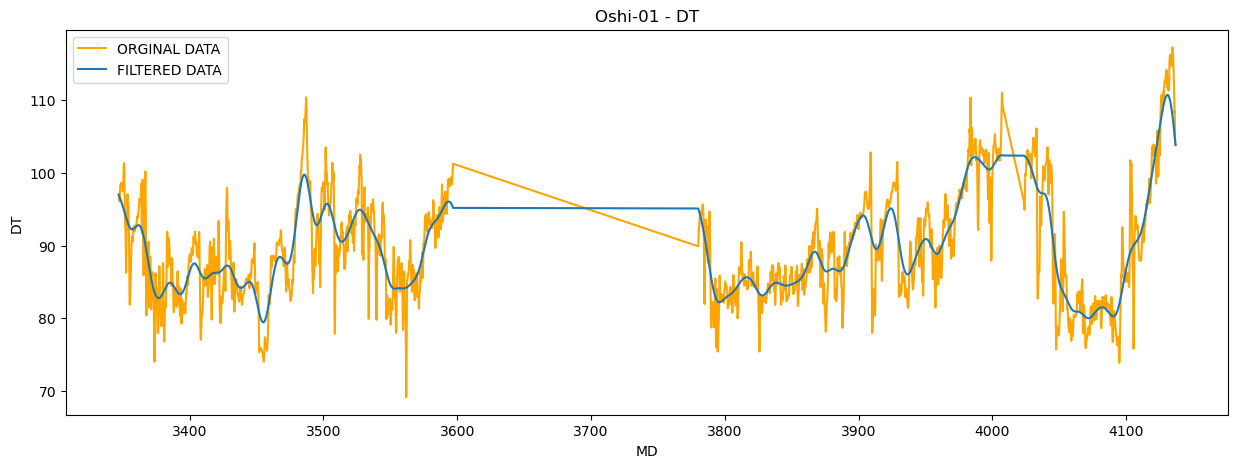

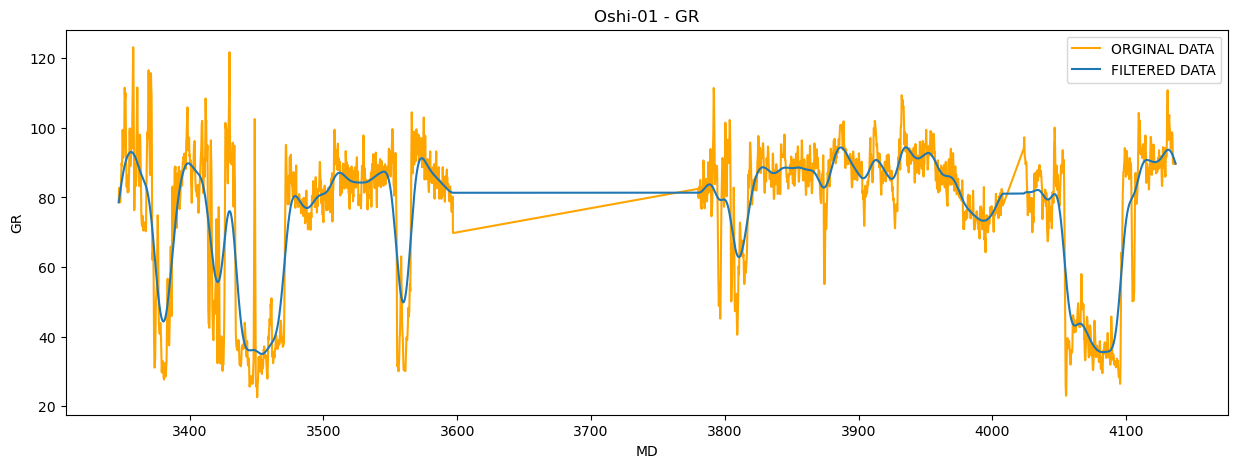

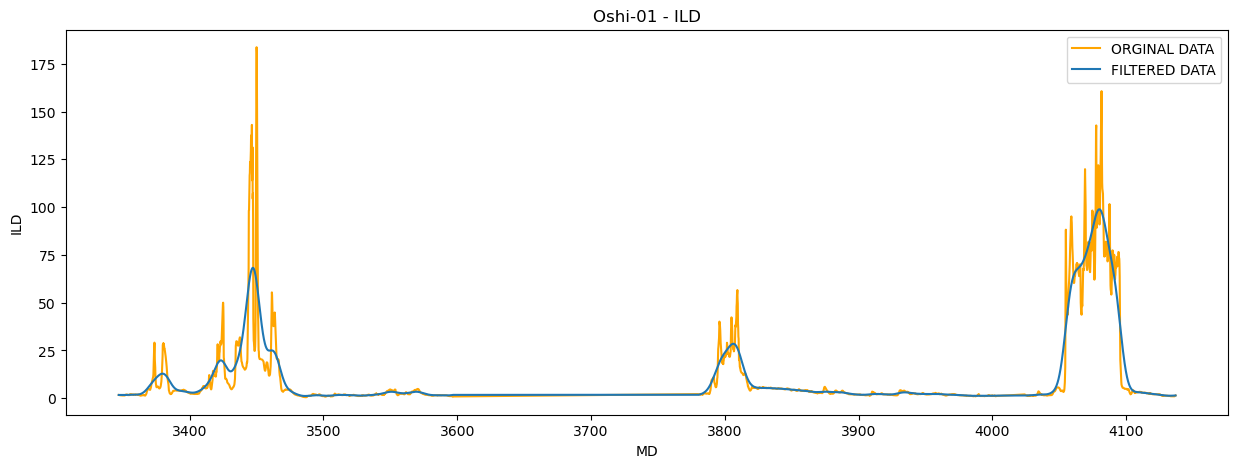

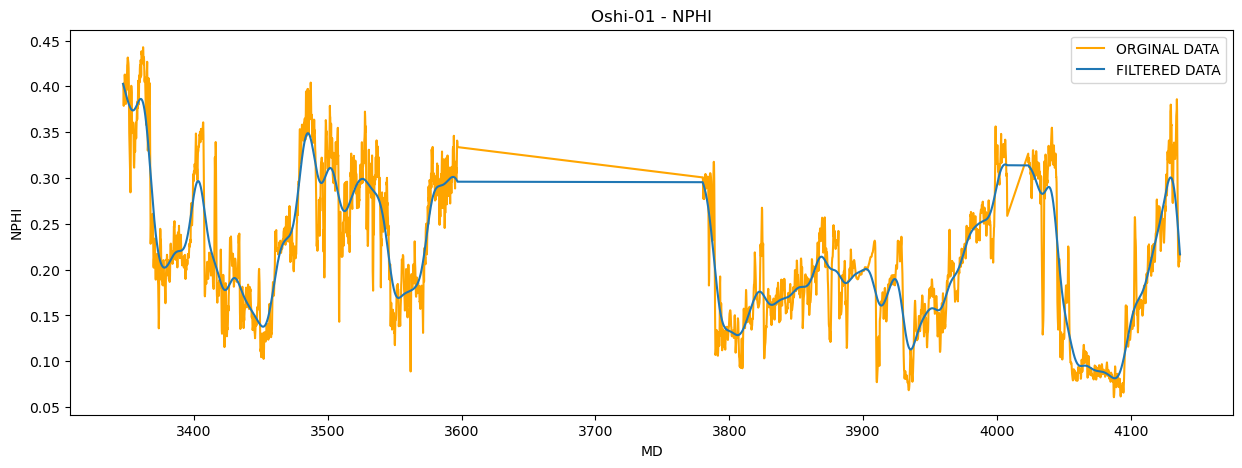

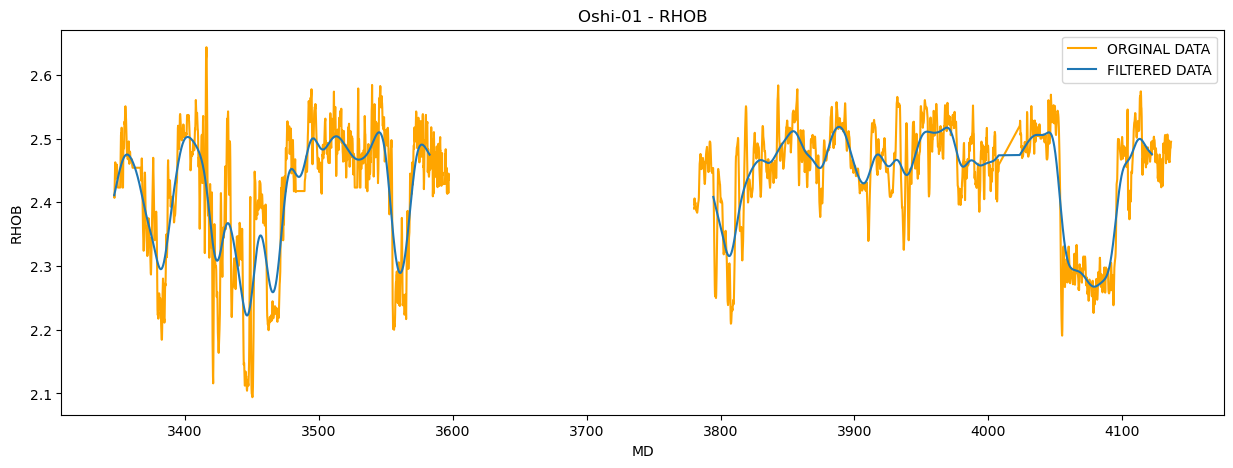

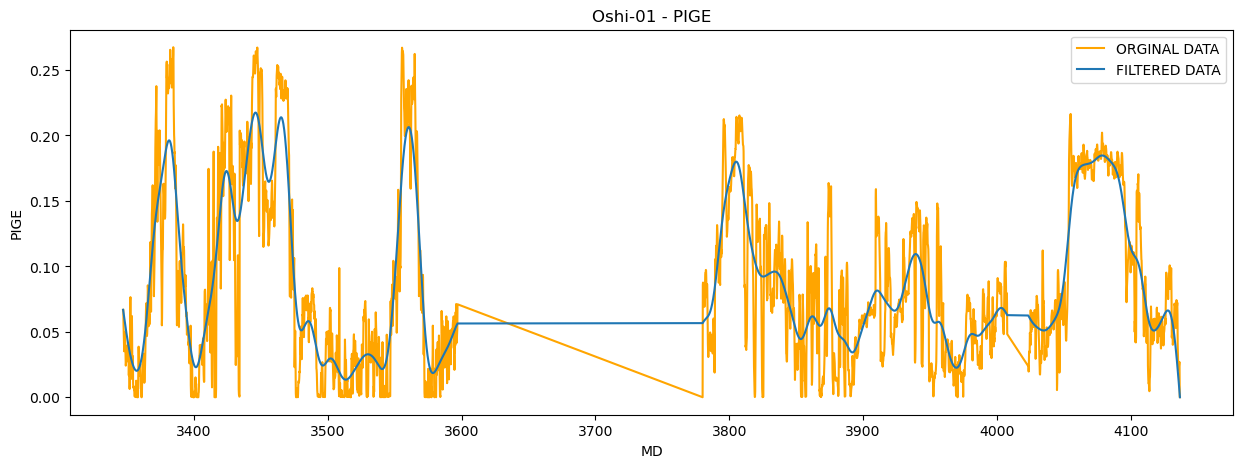

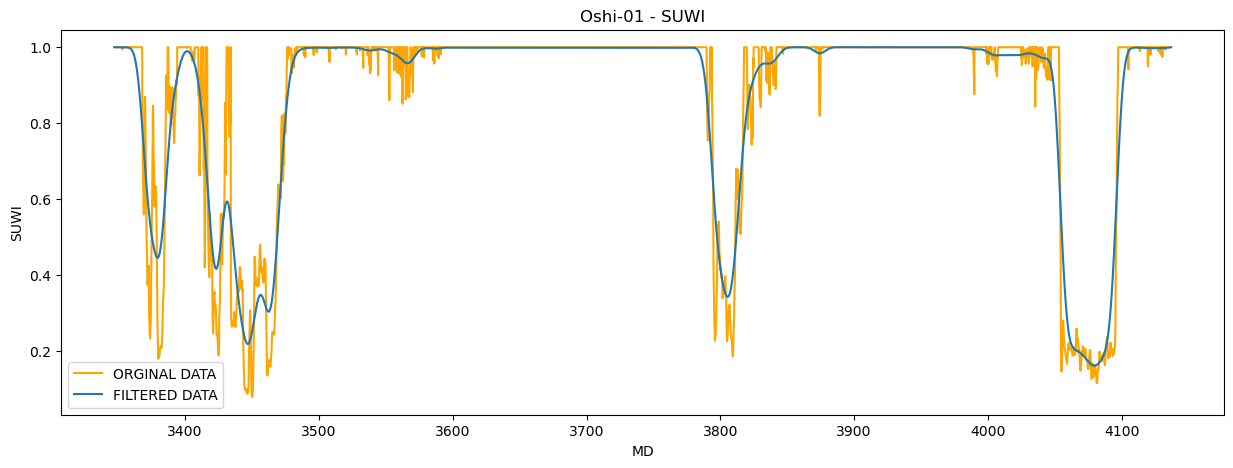

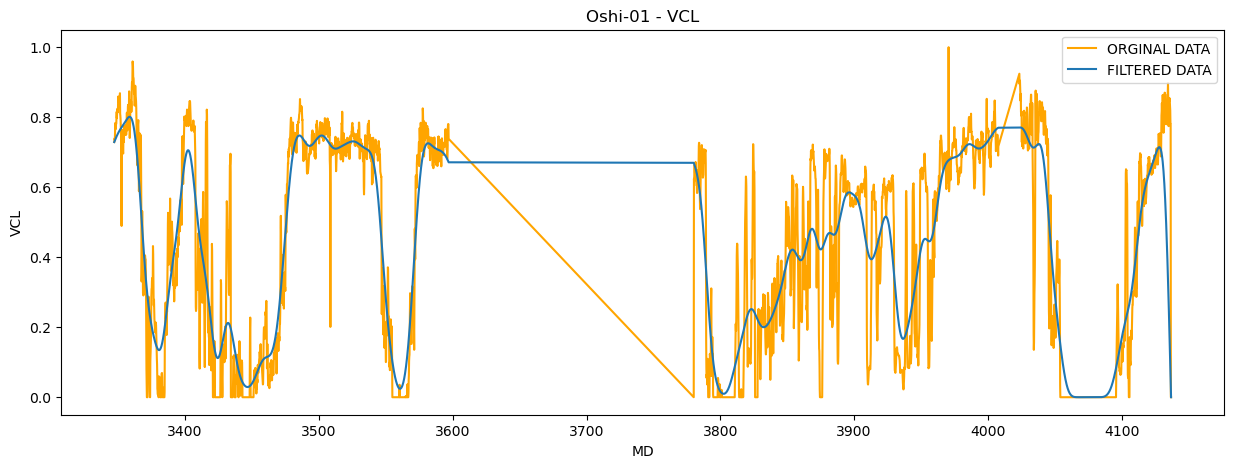

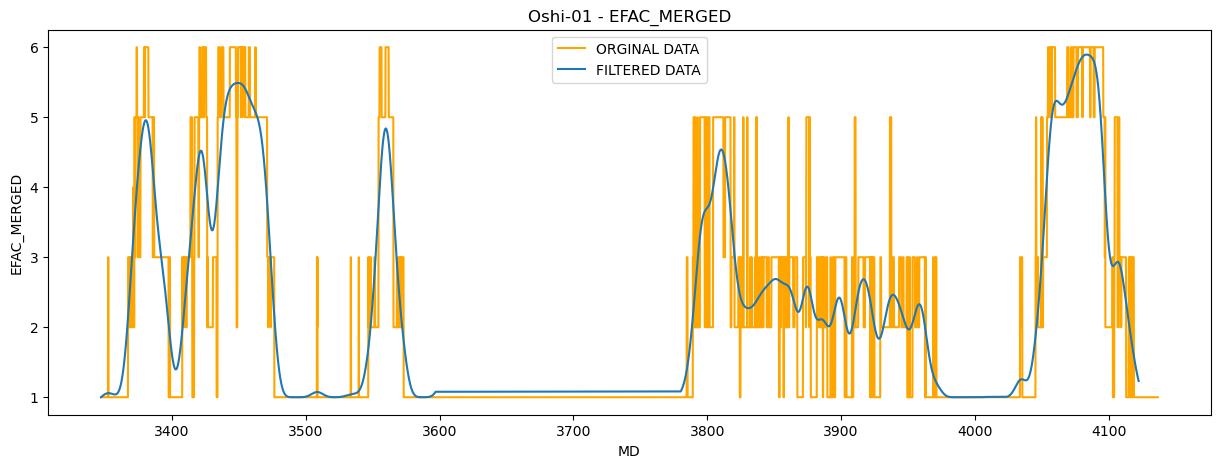

Filter order 'n' is greater than the length of the data for well Oshi-03 and feature DT.
Filter order 'n' is greater than the length of the data for well Oshi-03 and feature GR.
Filter order 'n' is greater than the length of the data for well Oshi-03 and feature ILD.
Filter order 'n' is greater than the length of the data for well Oshi-03 and feature NPHI.
Filter order 'n' is greater than the length of the data for well Oshi-03 and feature RHOB.
Filter order 'n' is greater than the length of the data for well Oshi-03 and feature PIGE.
Filter order 'n' is greater than the length of the data for well Oshi-03 and feature SUWI.
Filter order 'n' is greater than the length of the data for well Oshi-03 and feature VCL.
Filter order 'n' is greater than the length of the data for well Oshi-03 and feature EFAC_MERGED.


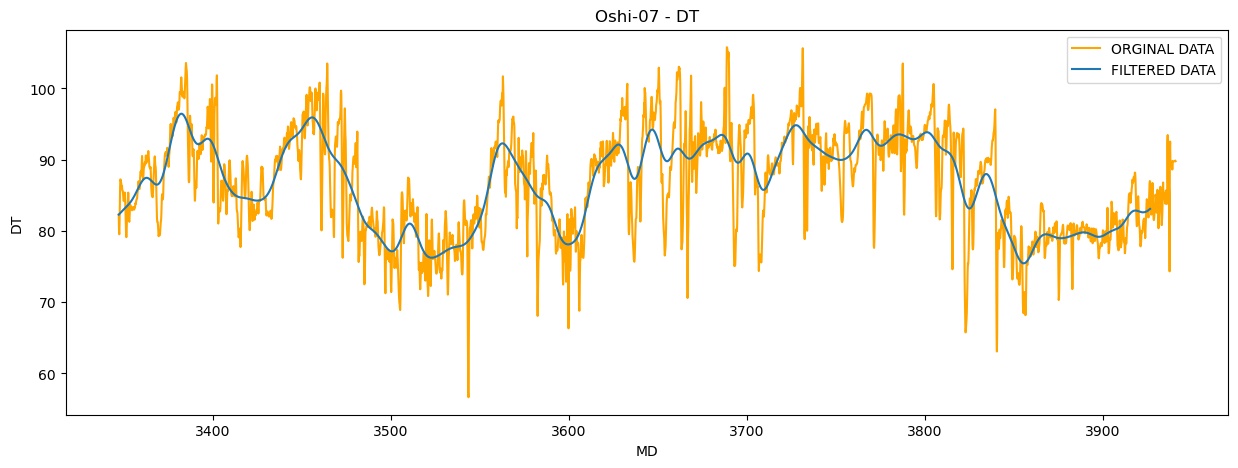

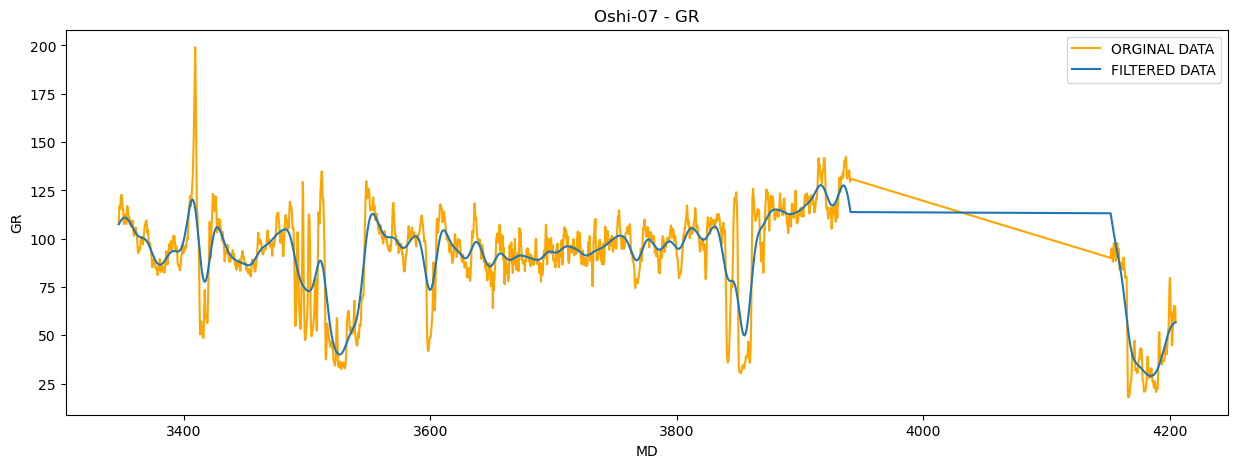

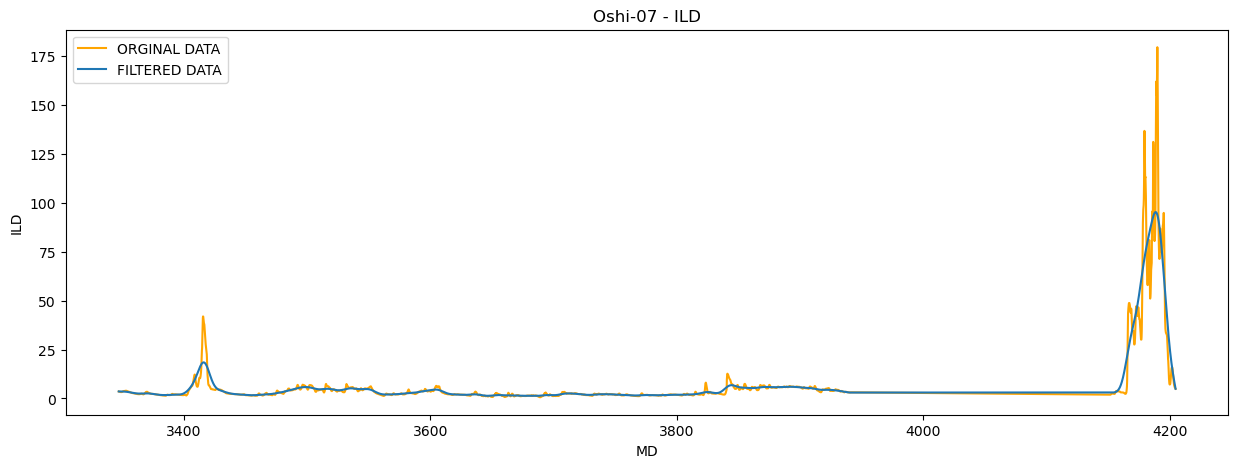

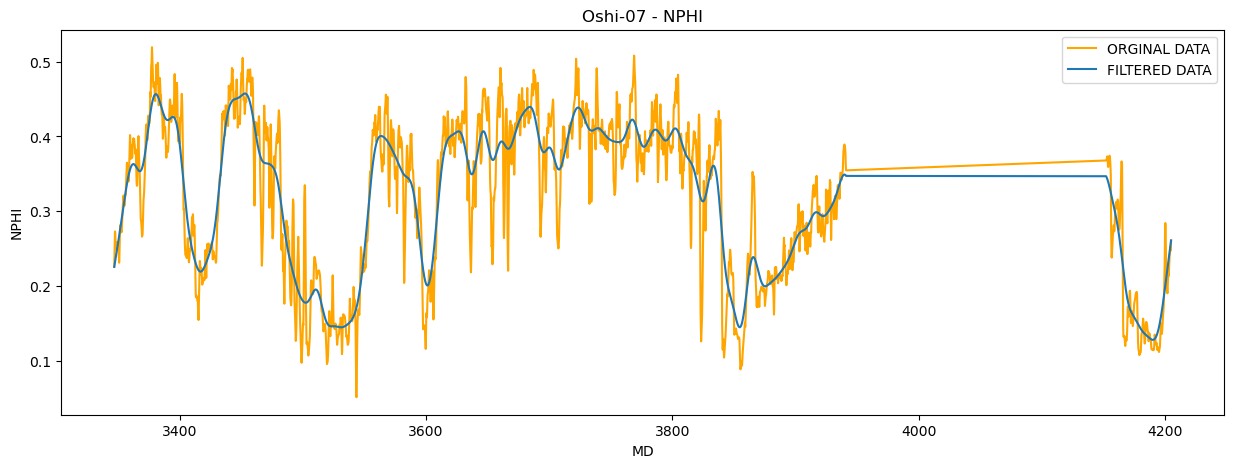

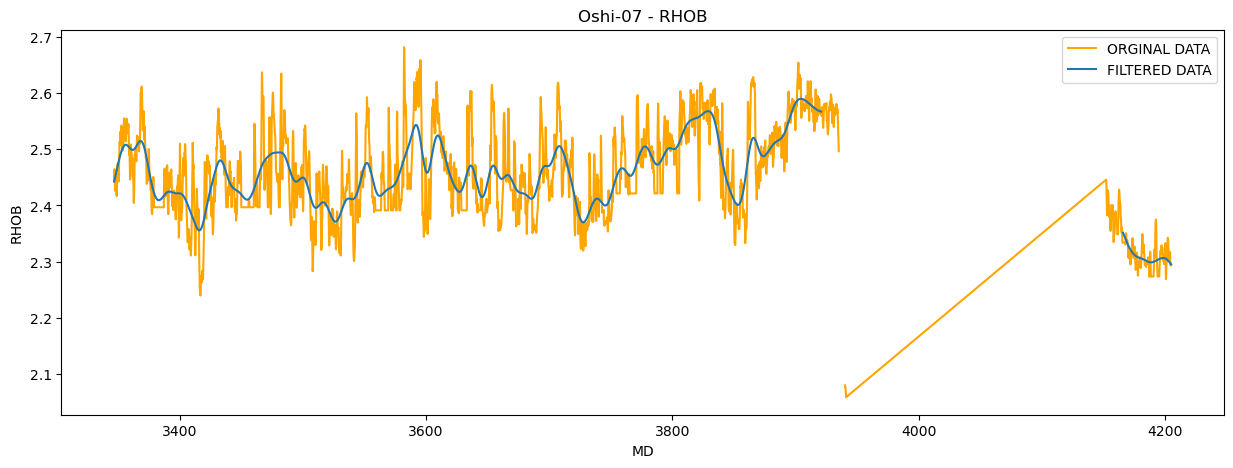

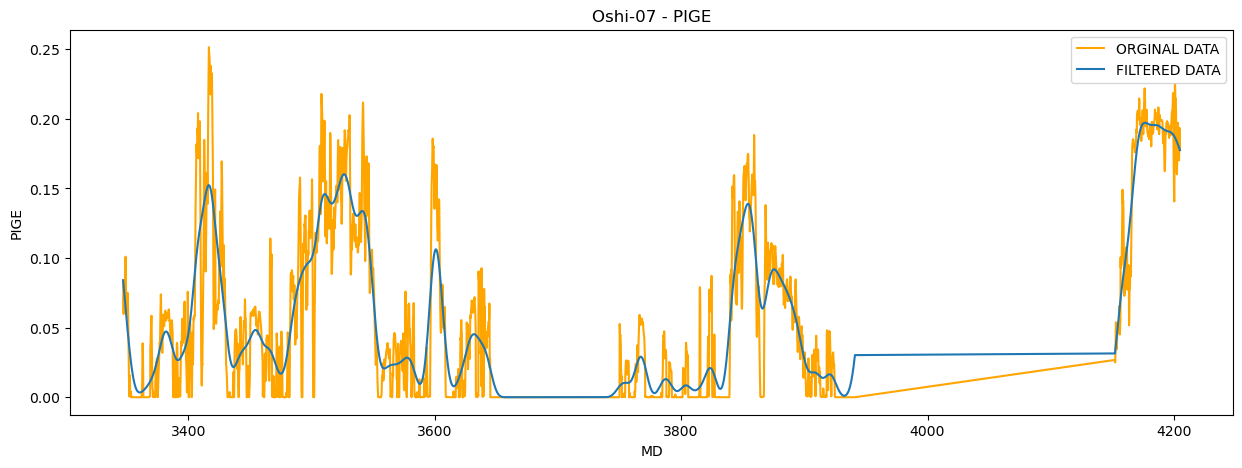

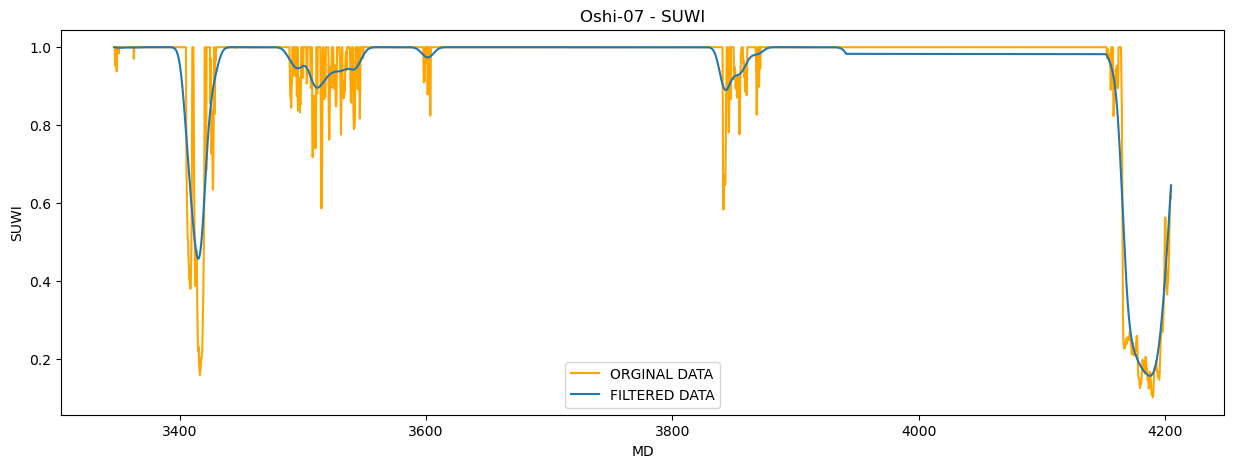

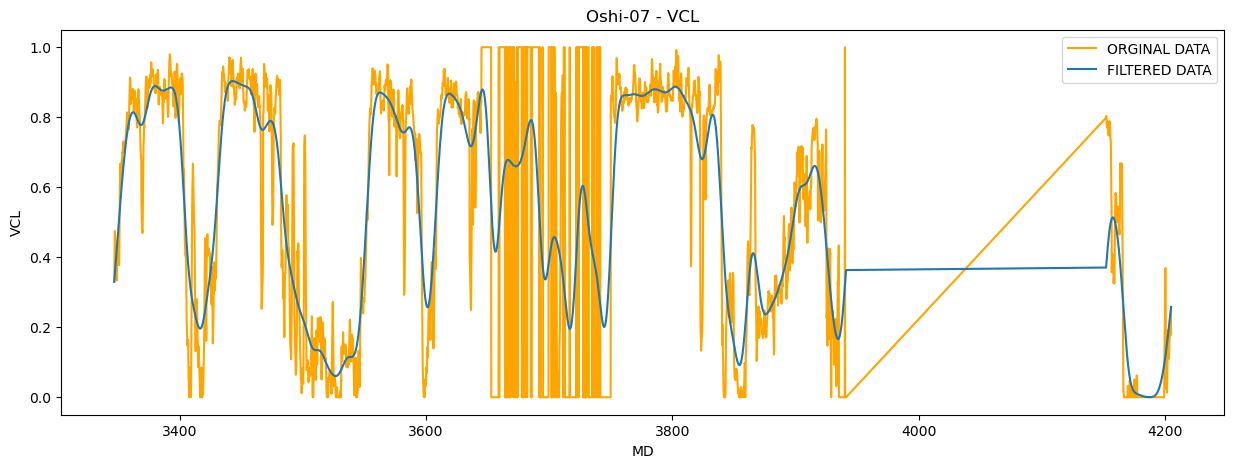

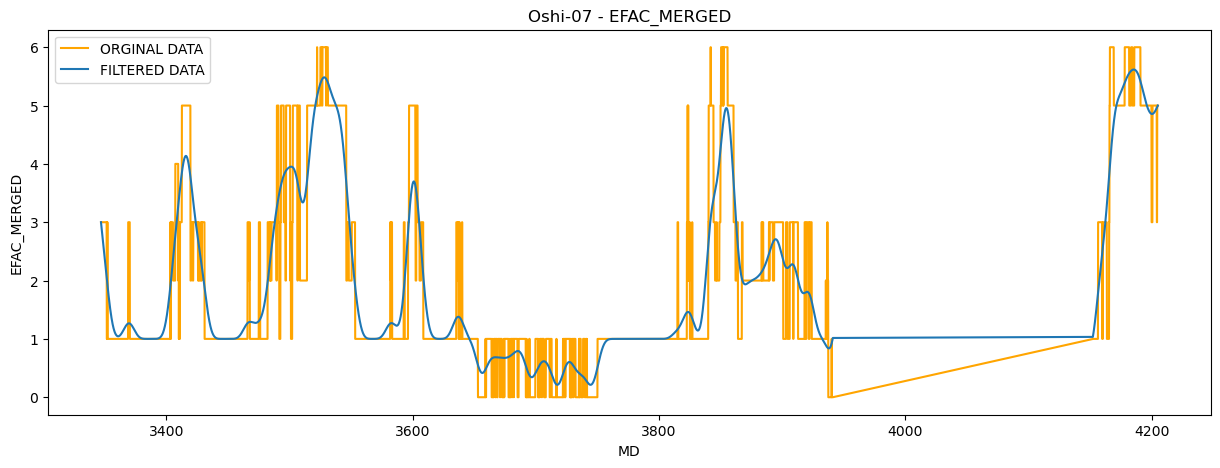

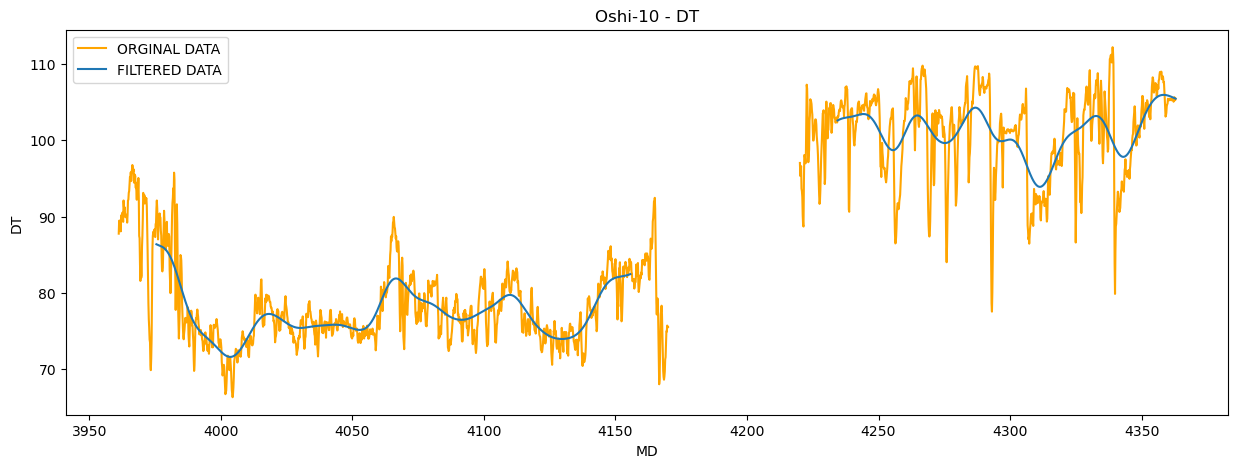

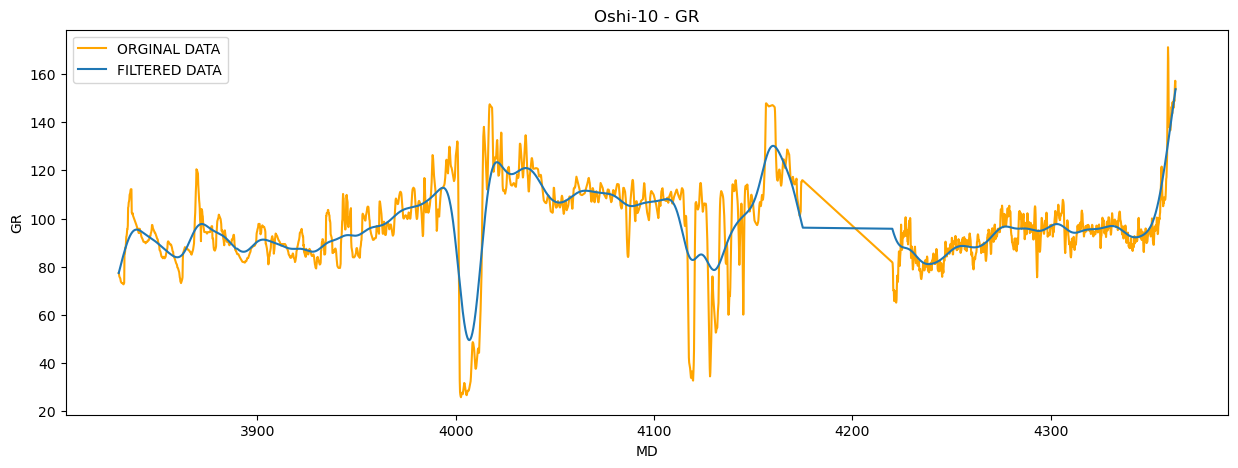

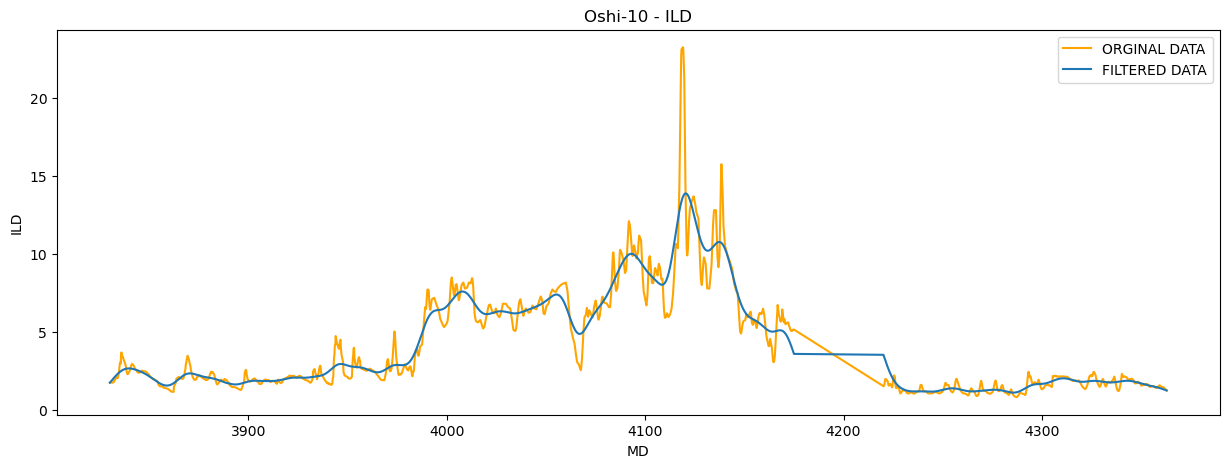

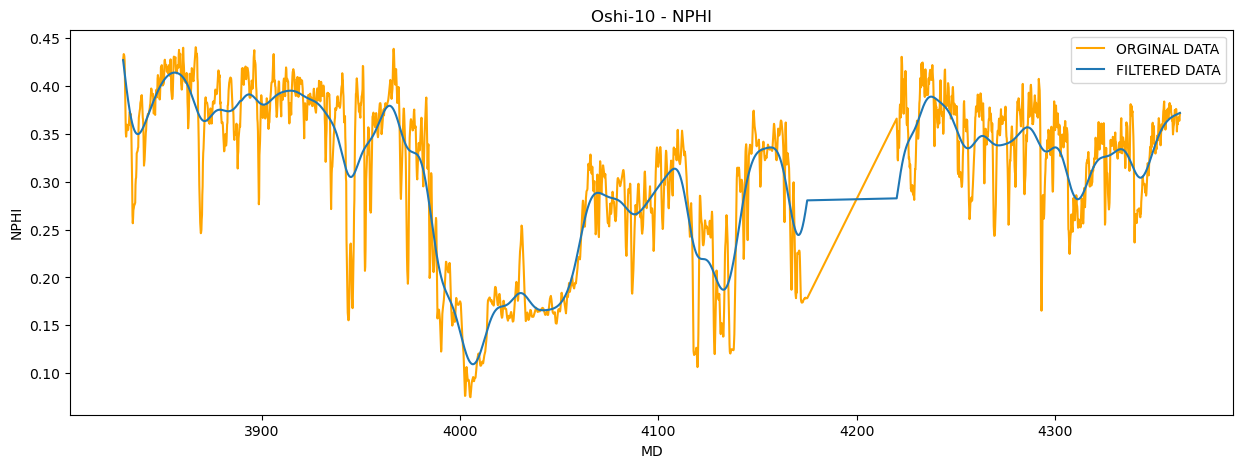

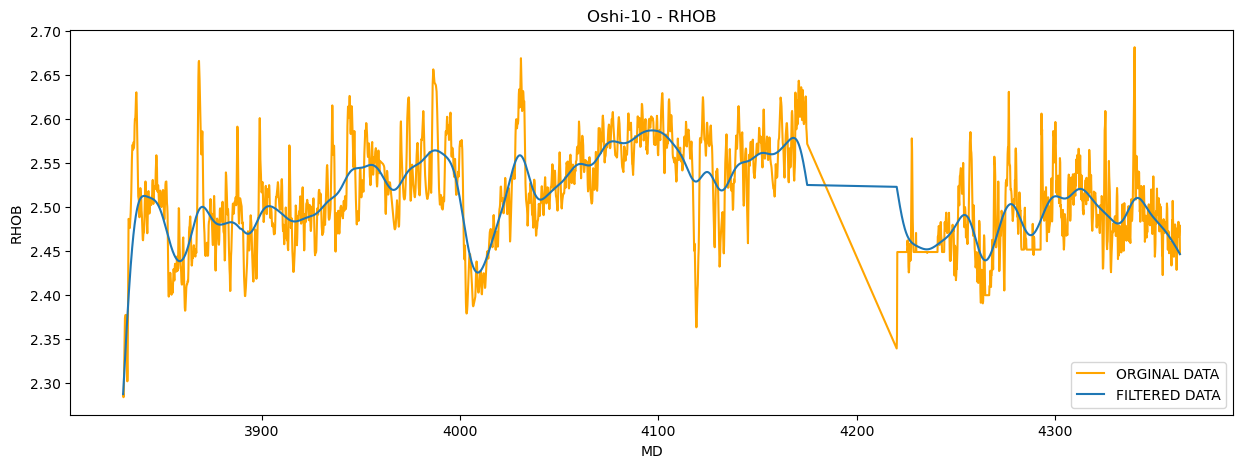

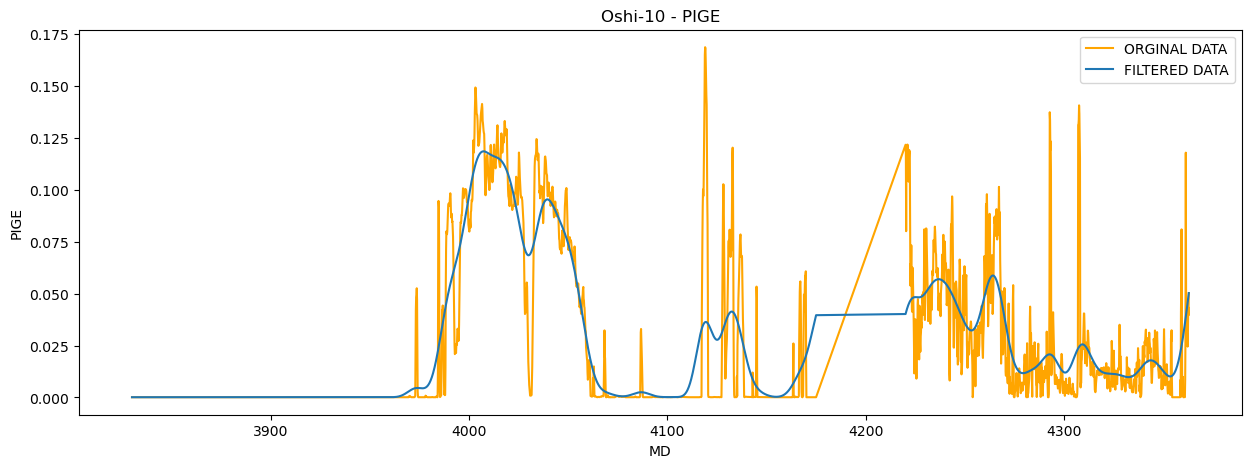

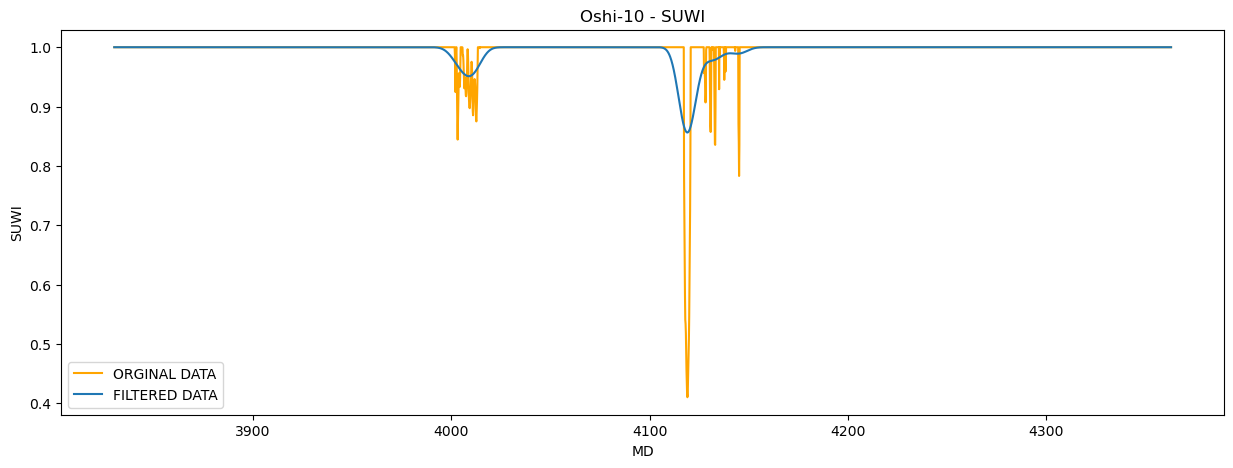

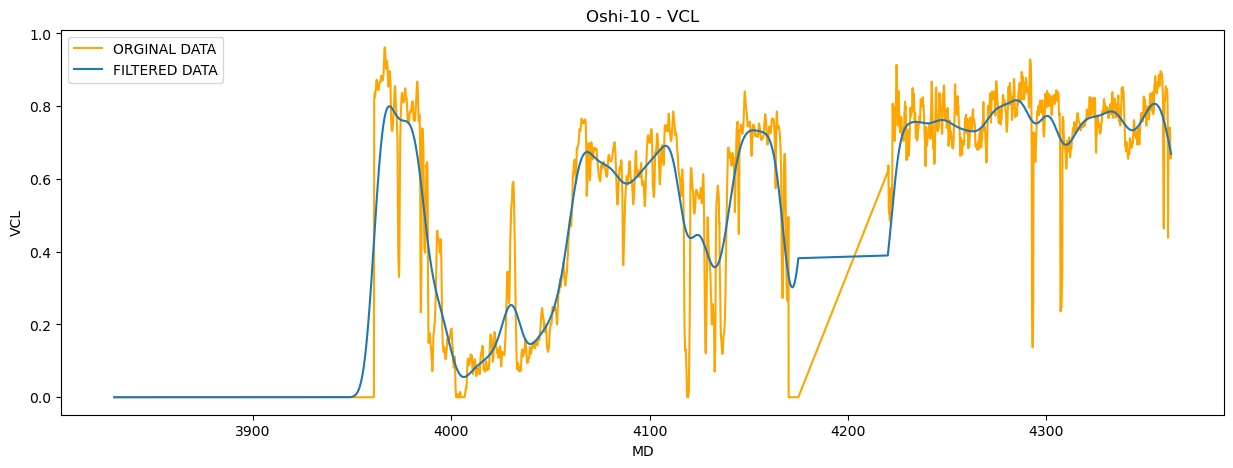

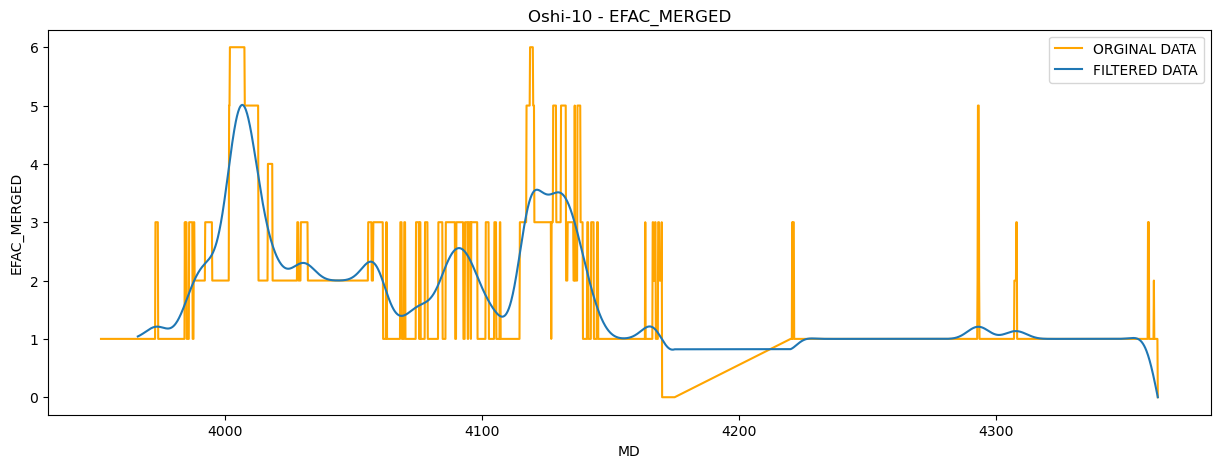

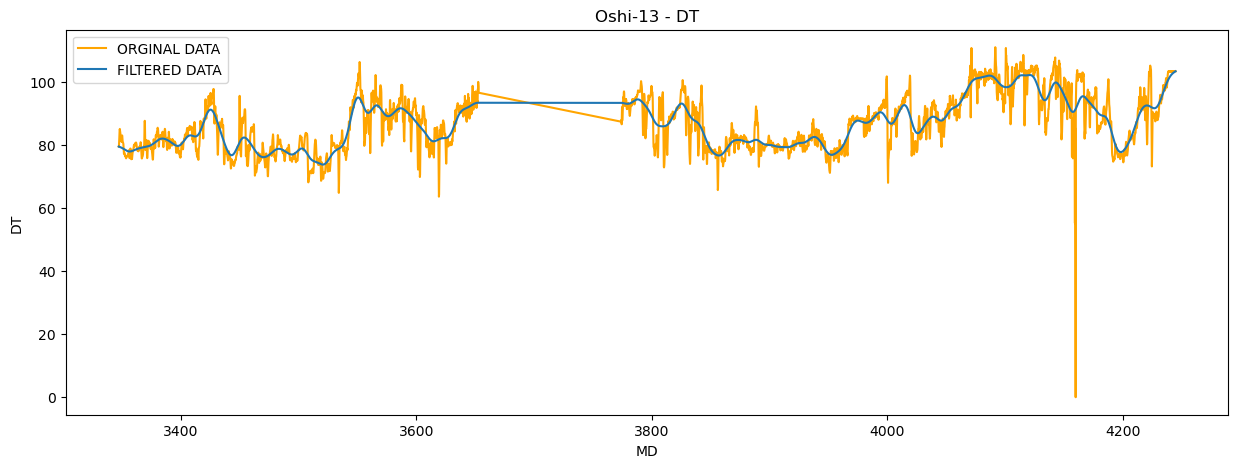

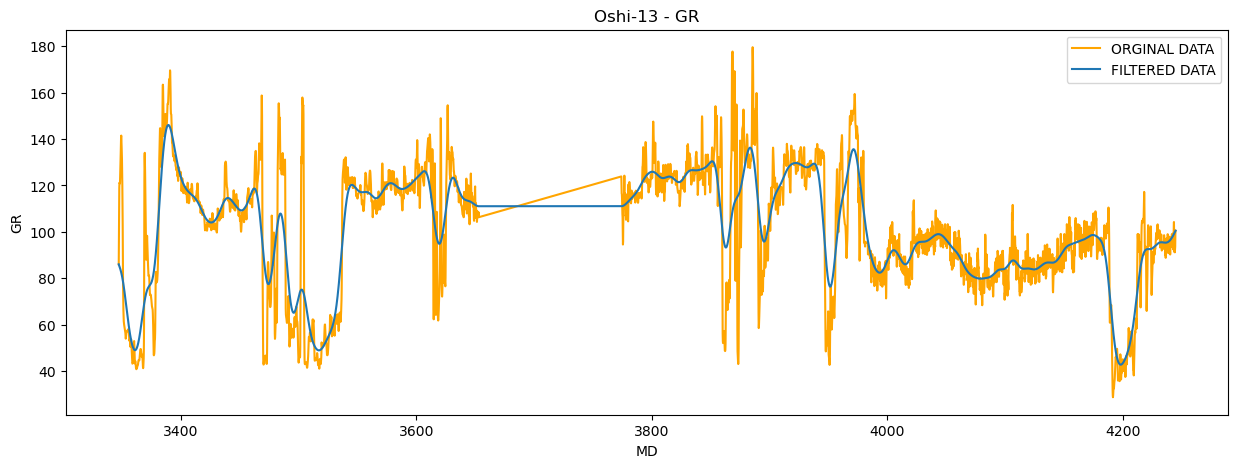

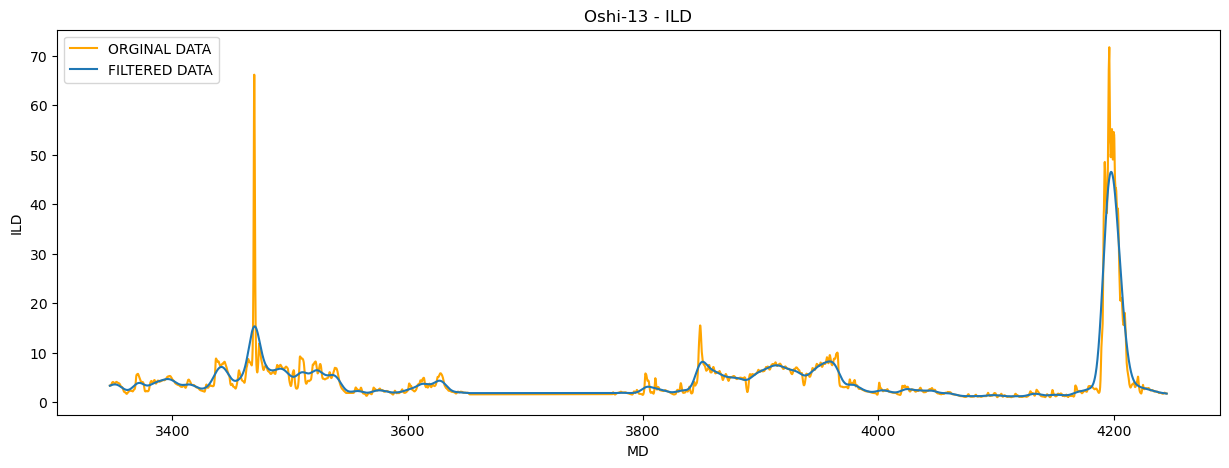

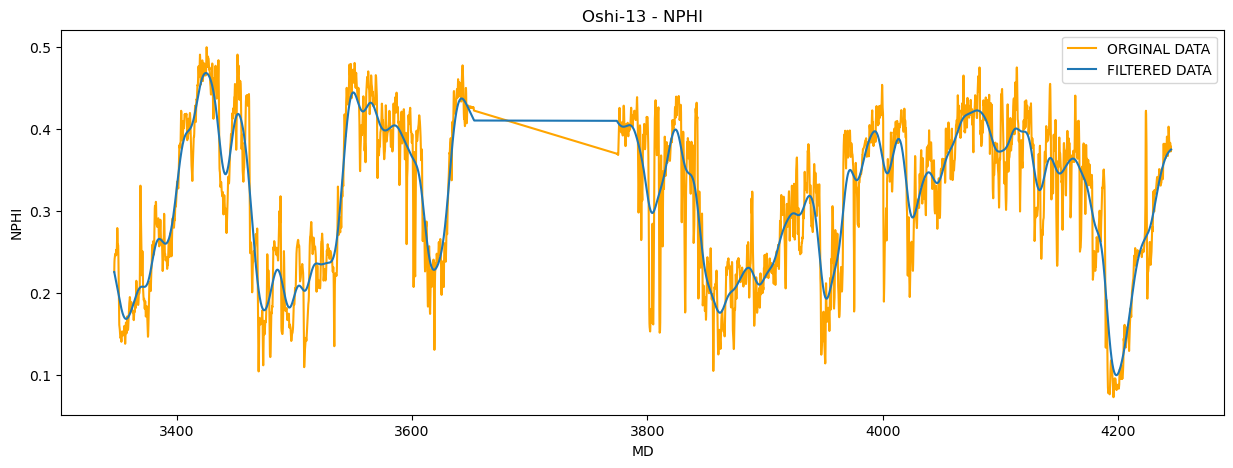

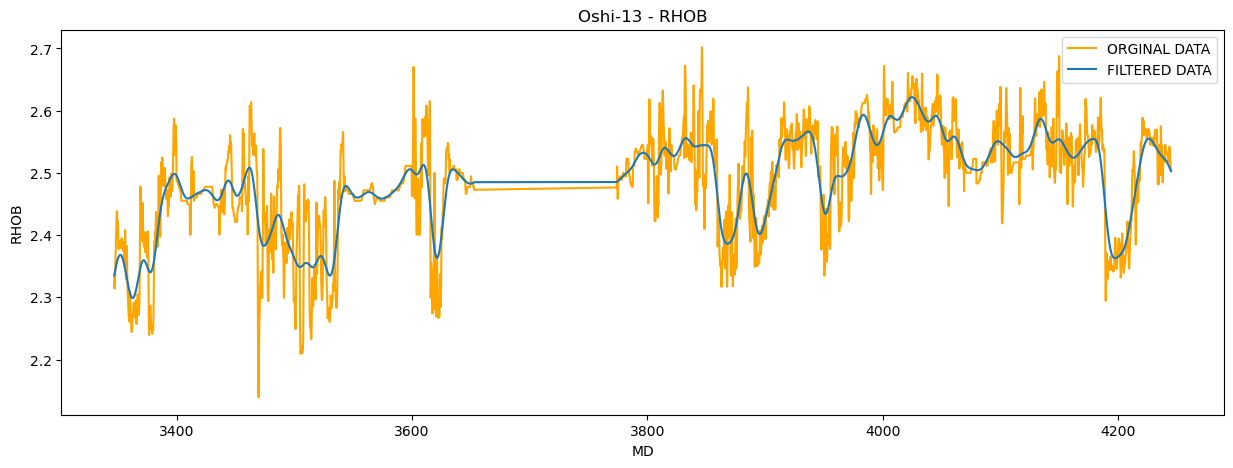

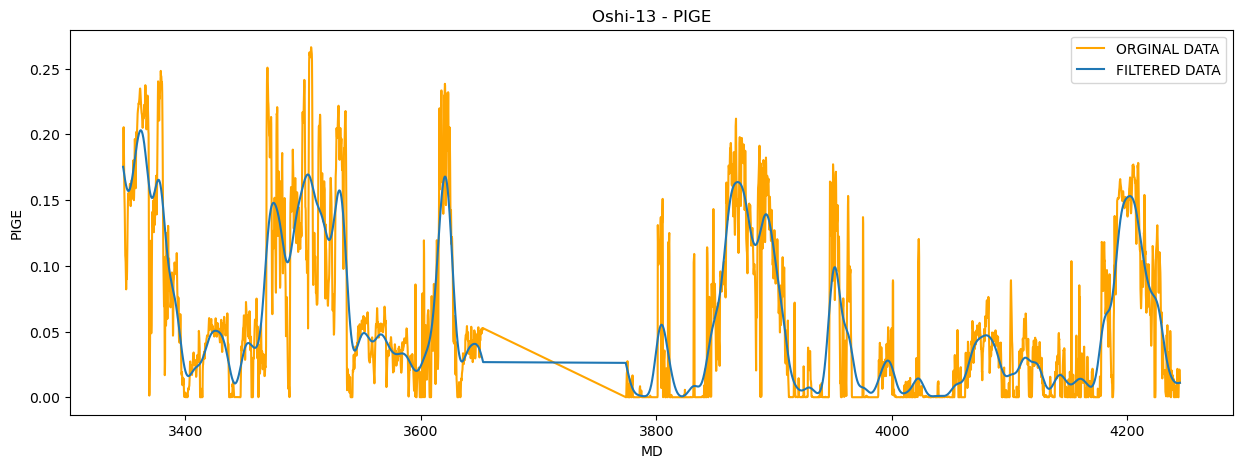

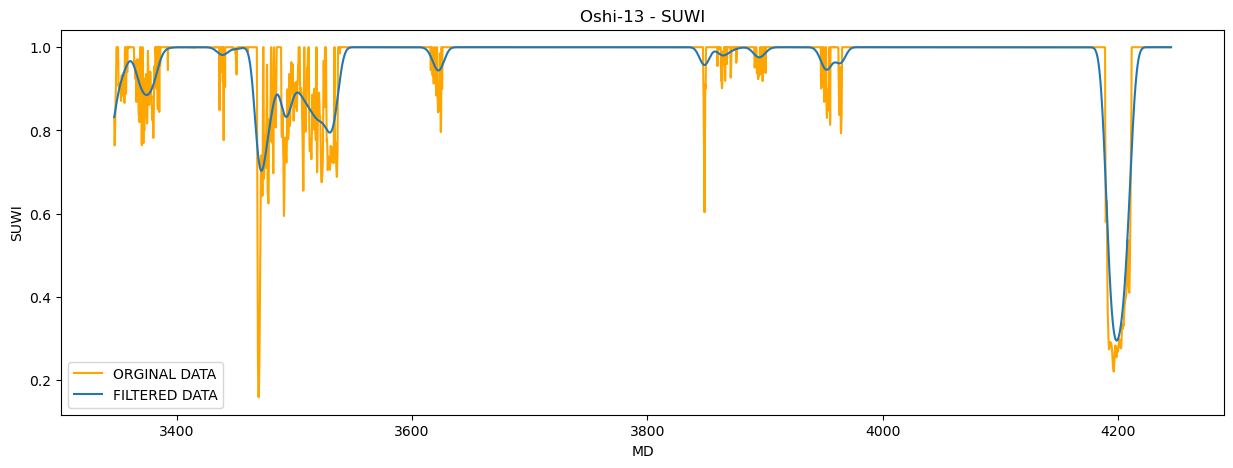

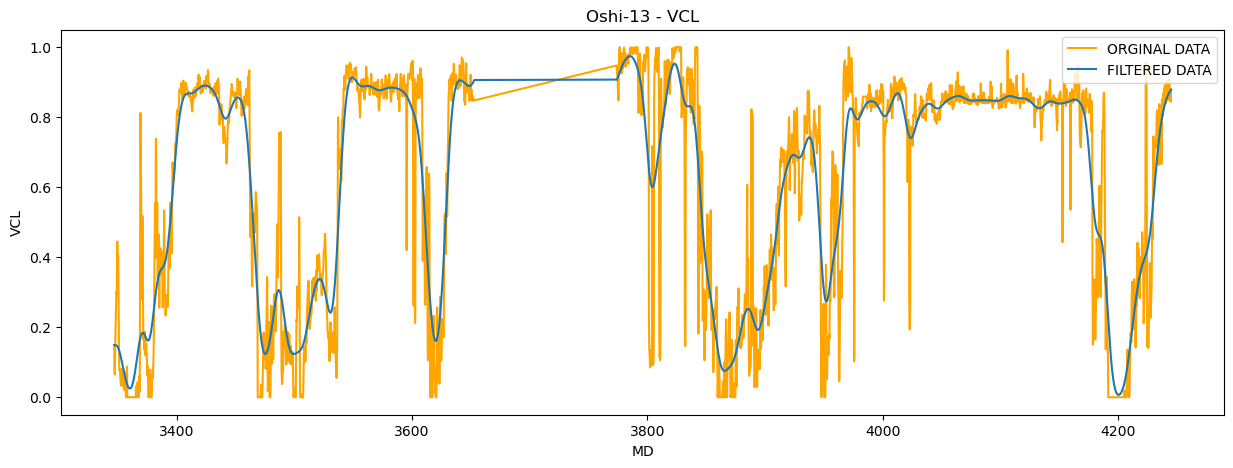

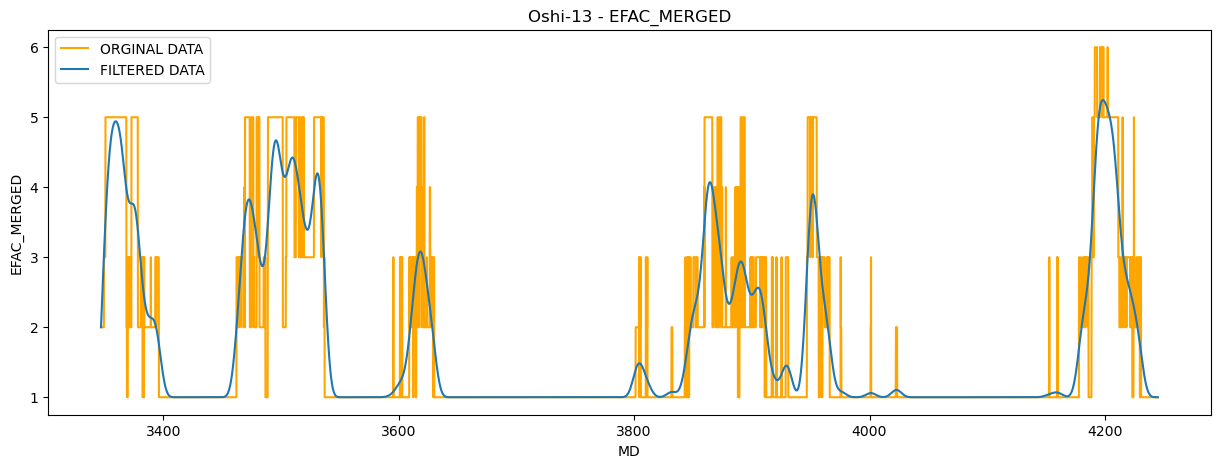

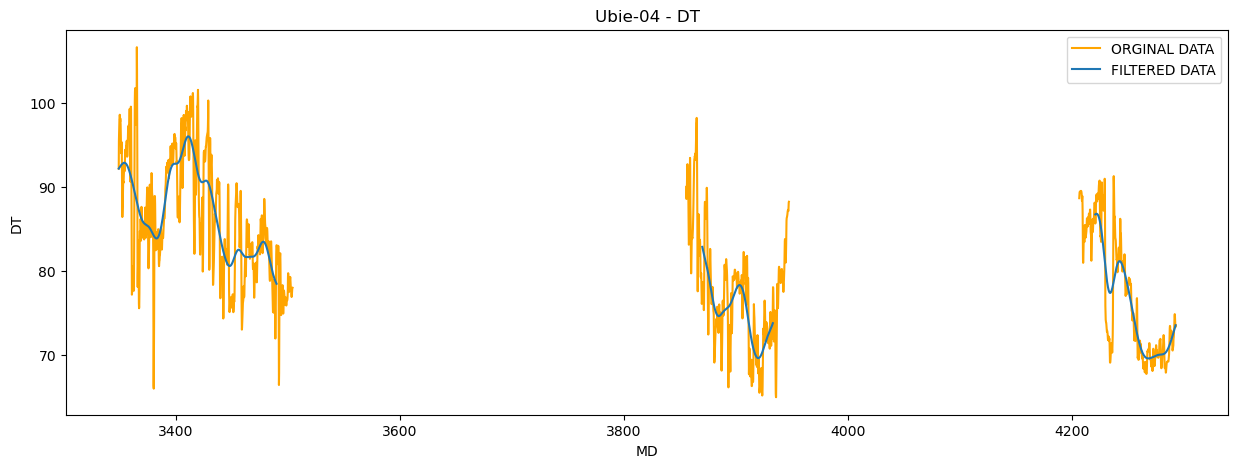

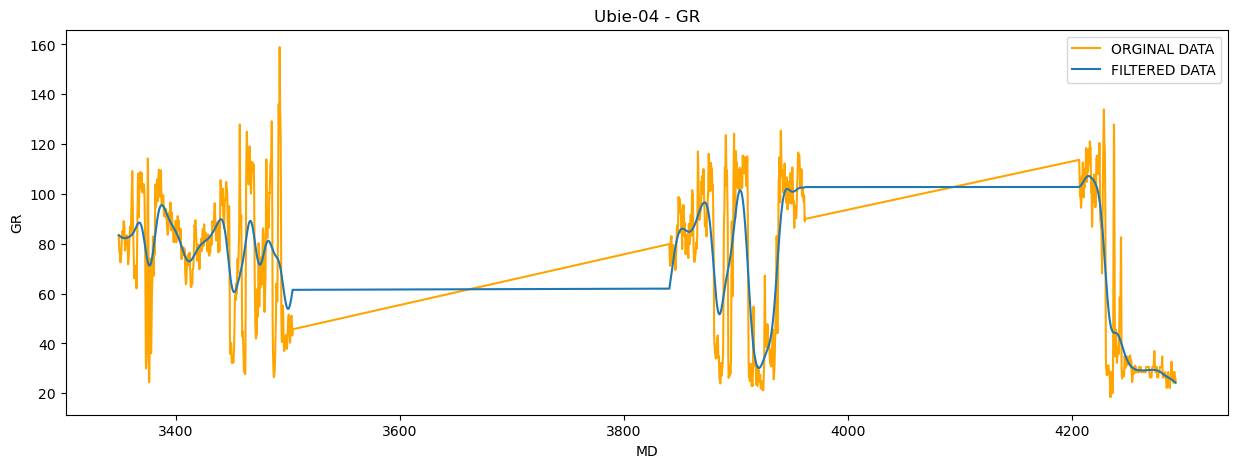

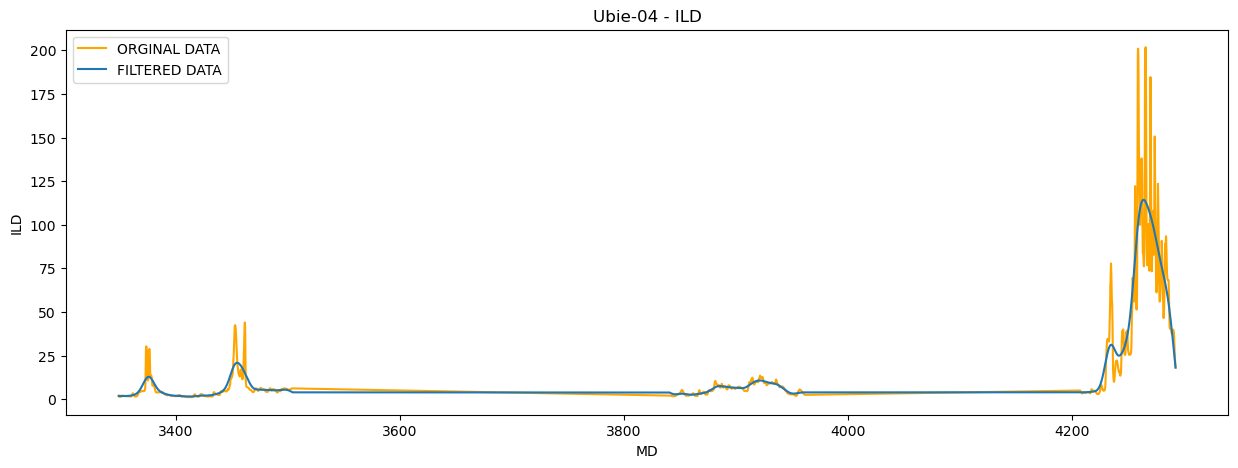

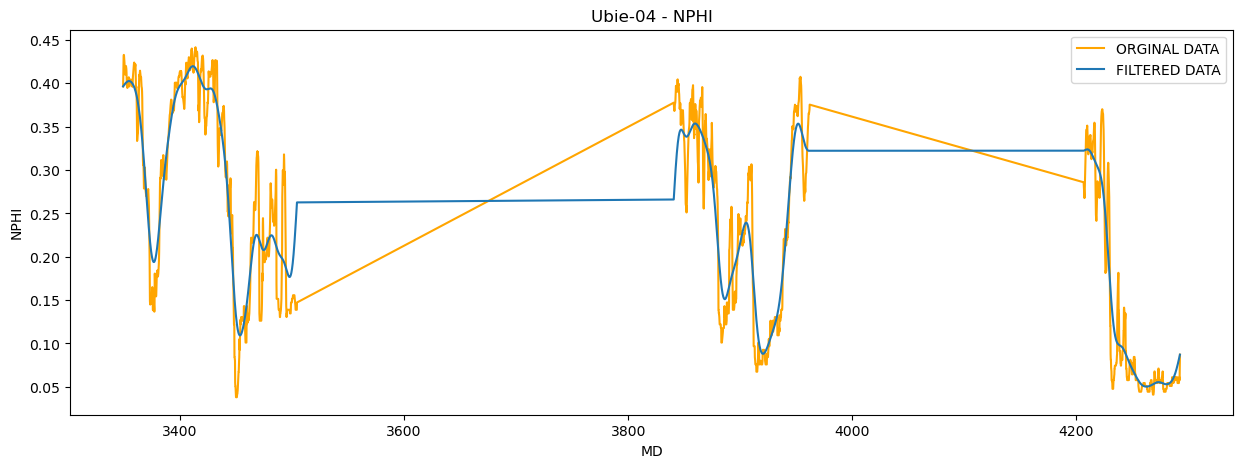

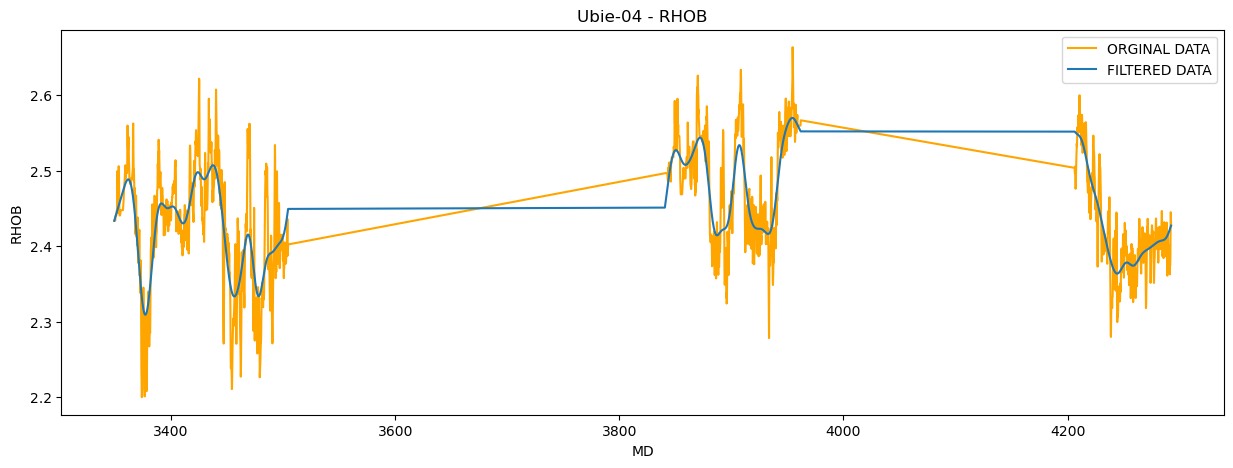

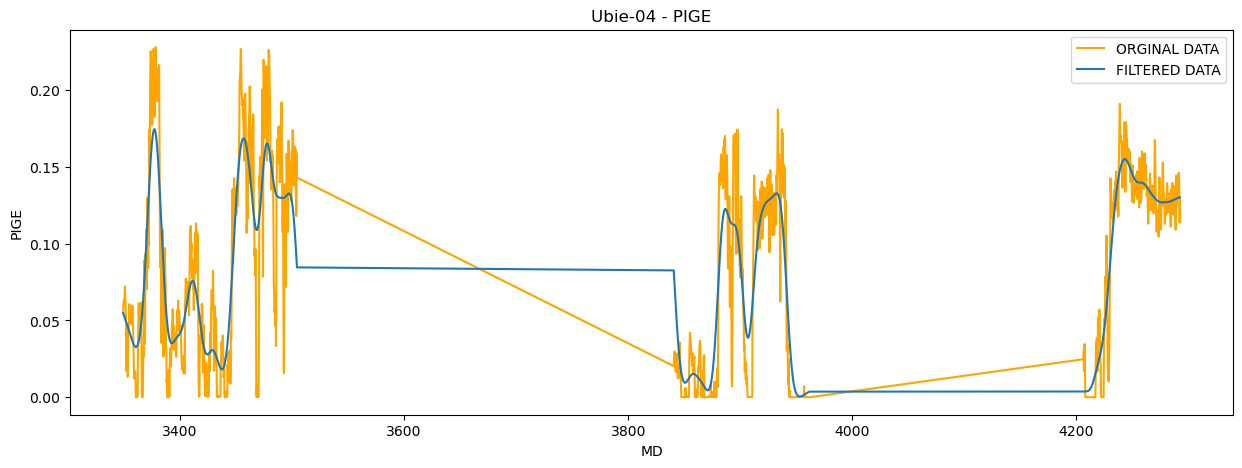

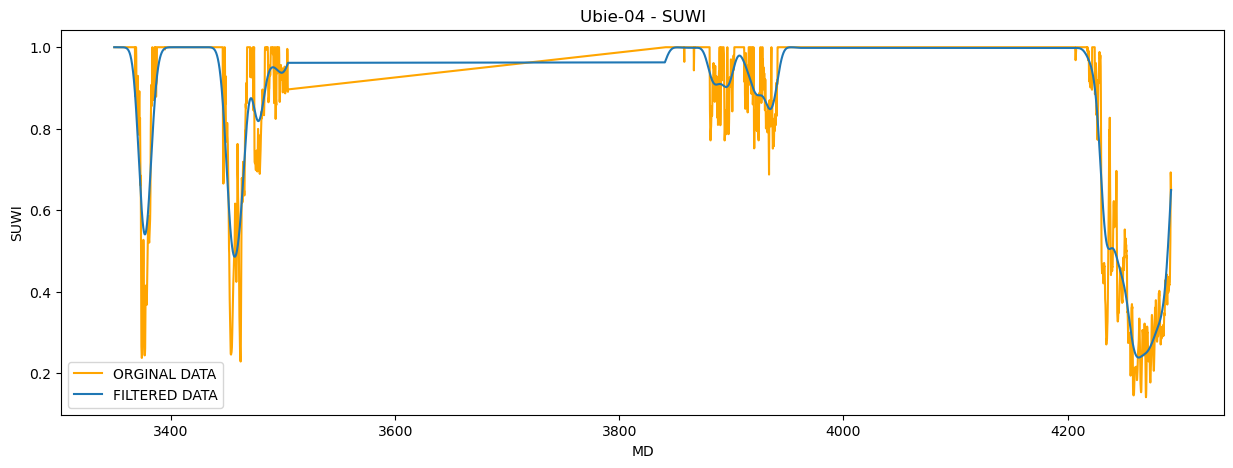

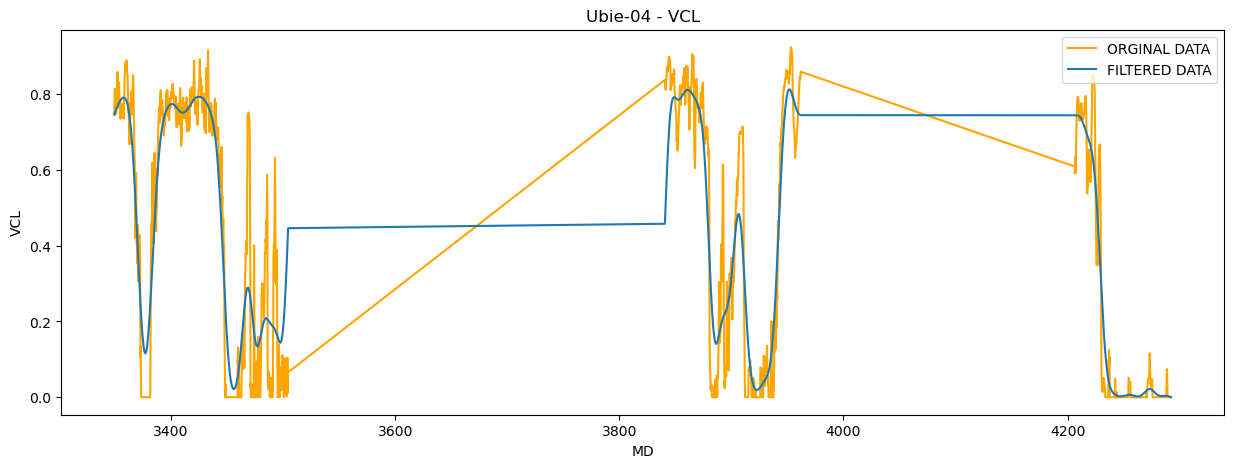

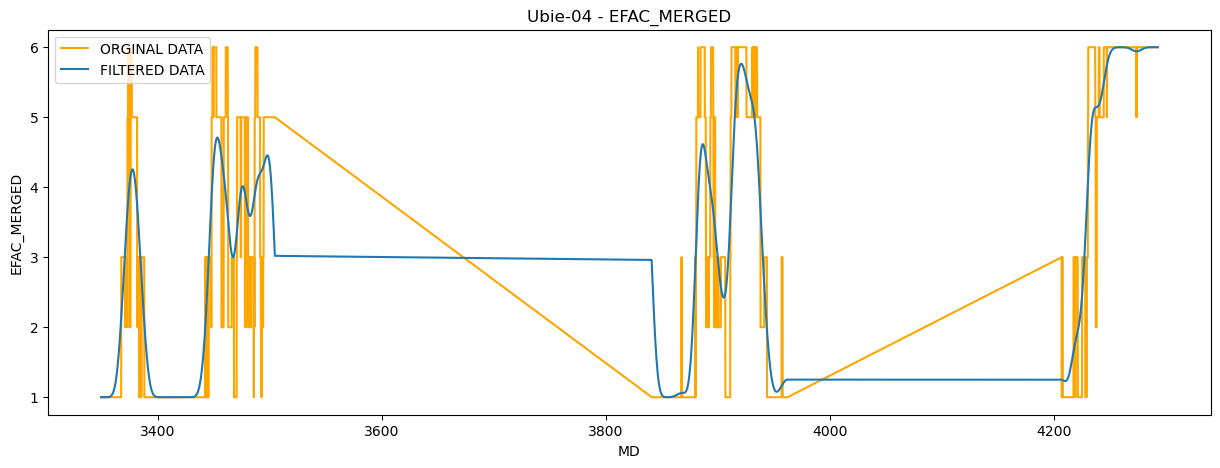

In [69]:
 def filter_all_wells(df_well_og, n, m):
    filtered_data = pd.DataFrame()
    for well in df_well_og['WELL'].unique():
        dfff = df_well_og[df_well_og['WELL'] == well]
        well_filtered = {'WELL': well, 'MD': dfff['MD'].values}
        for feature in dfff.columns:
            if feature in ['WELL', 'MD']:  # to skip 'WELL' and 'MD'
                continue
            data = dfff[feature].values
            if len(data) < n:
                print(f"Filter order 'n' is greater than the length of the data for well {well} and feature {feature}.")
                continue
            dt = (dfff['MD'].values[1] - dfff['MD'].values[0]).round(4)  
            fNQ = 1 / dt / 2
            if m <= 0 or m >= fNQ:
                print(f"Cutoff frequency 'm' must be between 0 and the Nyquist frequency for well {well} and feature {feature}.")
                continue
            Wn = m / fNQ
            b = firwin(n, Wn)
            filtered_values = filtfilt(b, 1, data)
            well_filtered[feature] = filtered_values
#             well_filtered[feature + '_filtered'] = filtered_values
            
        filt=pd.DataFrame(well_filtered)
        filt=filt.sort_values(by='MD')
#         display(filt)

        for feature in filt.columns:
            if f"{well}_" in feature or feature in ['MD', 'WELL']:
                continue
            plt.figure(figsize=(15, 5))
            plt.plot(dfff['MD'], dfff[feature], color='orange', label='ORGINAL DATA')
            plt.plot(filt['MD'], filt[feature], label="FILTERED DATA")
            plt.xlabel('MD')
            plt.ylabel(feature)
            plt.title(f'{well} - {feature}')
            plt.legend()
            plt.show()
            
        filtered_data = pd.concat([filtered_data, filt], ignore_index=True)
    return filtered_data

n = int(input("Enter Filter Order (n): "))
m = float(input("Enter Cutoff Frequency (m): "))
df_well = filter_all_wells(df_well_og, n, m)
# display(filtered_data)

In [70]:
df_well['WELL'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-04'],
      dtype=object)

In [71]:
len(df_well ['WELL'].unique())

6

tdr data

In [72]:
import os
import pandas as pd

def tdr_data(folder_path, skip_rows):
    df_tdr = pd.DataFrame()

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.txt'):
            with open(file_path, 'r') as file:
                dataframe1 = pd.read_csv(file, skiprows=skip_rows, header=None, sep="\s+|\t")
                dataframe1['Well name'] = filename.split("_")[0]
                #print(dataframe1)
                # df_tdr = df_tdr.append(dataframe1, ignore_index=True)
                df_tdr = pd.concat([df_tdr, dataframe1], ignore_index=True)
        
    df_tdr = df_tdr.rename(columns={0: 'MD',      
        1: 'TWT',})
    df_tdr = df_tdr[df_tdr != -999.2500]
    df_tdr = df_tdr.dropna()
    df_tdr = df_tdr.reset_index(drop=True)
    
    return df_tdr

if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            print("OVL skip 1 row")
            skip_rows = int(input("Enter the number of rows to skip: "))
            df_tdr = tdr_data(folder_path, skip_rows)
            display(df_tdr)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

OVL skip 1 row


Enter the number of rows to skip:  1


MD      TWT    Well name
0         0.00   -27.56  Oshi-01.txt
1         0.15   -27.41  Oshi-01.txt
2         0.30   -27.26  Oshi-01.txt
3         0.46   -27.11  Oshi-01.txt
4         0.61   -26.96  Oshi-01.txt
...        ...      ...          ...
57911  4382.41  3285.14  Ubie-04.txt
57912  4382.57  3285.22  Ubie-04.txt
57913  4382.72  3285.30  Ubie-04.txt
57914  4382.87  3285.38  Ubie-04.txt
57915  4383.02  3285.46  Ubie-04.txt

[57916 rows x 3 columns]

In [73]:
len(df_tdr['Well name'].unique())

6

In [74]:
df_tdr['Well name'].unique()

array(['Oshi-01.txt', 'Oshi-03.txt', 'Oshi-07.txt', 'Oshi-10.txt',
       'Oshi-13.txt', 'Ubie-04.txt'], dtype=object)

In [75]:
# Remove .txt in-place
df_tdr['Well name'] = df_tdr['Well name'].str.replace(r'\.txt$', '', regex=True)

# Tuple-like string
tuple_str = "(" + ",".join(df_tdr['Well name'].tolist()) + ")"

In [76]:
df_tdr['Well name'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-04'],
      dtype=object)

deviation data

In [78]:
def dev_data(folder_path,skip_rows):
    df_dev = pd.DataFrame()
    # df = pd.concat([df, pd.DataFrame([{'a':1, 'b':2}])], ignore_index=True)

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as file:
            df=pd.read_csv(file,skiprows=skip_rows,header=None,sep=" ")

            df=df.iloc[:,0:4]
            df['Well name']=filename
            df_dev = pd.concat([df_dev, df], ignore_index=True)
            # df_dev=df_dev.append(df)
    df_dev=df_dev.drop(columns=0)
    df_dev=df_dev.rename(columns={1:'MD',2:'X',3:'Y'})
    df_dev=df_dev.dropna()
    return df_dev

if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            print("OVL skip 18 row")
            skip_rows=int(input("Enter the number of rows to skip :"))
            df_dev = dev_data(folder_path,skip_rows)
            display(df_dev)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

OVL skip 18 row


Enter the number of rows to skip : 18


MD             X             Y Well name
0       0.000000  452430.01000  121349.00000   Oshi-01
1      89.610000  452429.58151  121348.12147   Oshi-01
2     517.245000  452424.06113  121336.80300   Oshi-01
3     944.880000  452415.67990  121319.61895   Oshi-01
4    1371.600000  452408.33610  121304.56193   Oshi-01
..           ...           ...           ...       ...
443  4299.421714  457656.52173  121741.71635   Ubie-04
444  4320.322286  457657.41441  121741.52956   Ubie-04
445  4341.222857  457658.05214  121741.39612   Ubie-04
446  4362.123429  457658.43482  121741.31605   Ubie-04
447  4383.024000  457658.56239  121741.28936   Ubie-04

[448 rows x 4 columns]

In [79]:
df_dev['Well name'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-04'],
      dtype=object)

In [80]:
len(df_dev['Well name'].unique())

6

In [84]:
df_well['WELL'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-04'],
      dtype=object)

In [85]:
df_tdr['Well name'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-04'],
      dtype=object)

In [86]:
df_tdr

MD      TWT Well name
0         0.00   -27.56   Oshi-01
1         0.15   -27.41   Oshi-01
2         0.30   -27.26   Oshi-01
3         0.46   -27.11   Oshi-01
4         0.61   -26.96   Oshi-01
...        ...      ...       ...
57911  4382.41  3285.14   Ubie-04
57912  4382.57  3285.22   Ubie-04
57913  4382.72  3285.30   Ubie-04
57914  4382.87  3285.38   Ubie-04
57915  4383.02  3285.46   Ubie-04

[57916 rows x 3 columns]

Well data are in the time domain; hence, this code is used to add a time column using TDR. Consequently, the well data will be available in the time domain for each of the available wells.

In [87]:
def update_well_twt(df_well, df_tdr):
    dfm = pd.DataFrame()
    for well_name in df_tdr['Well name'].unique():
        df_ms = df_well[df_well['WELL'] == well_name]
        df_n = df_tdr[df_tdr['Well name'] == well_name]
        
        if df_n.empty or df_ms.empty:
            continue
        X = df_n[['MD']].values
        Y = df_n[['TWT']].values
        knr = KNeighborsRegressor(n_neighbors=1)
        knr.fit(X, Y)
        X_pred = df_ms[['MD']].values
        X_Y = knr.predict(X_pred)
        df_ms[['TWT']] = X_Y
        dfm = pd.concat([dfm, df_ms], ignore_index=True)
        print(dfm)
    return dfm

In [88]:
dfm = update_well_twt(df_well, df_tdr)

         WELL          MD          DT         GR       ILD      NPHI  \
0     Oshi-01  3347.00926   97.019440  78.616180  1.708760  0.402680   
1     Oshi-01  3347.16166   96.943041  79.040693  1.706987  0.401835   
2     Oshi-01  3347.31406   96.866536  79.464686  1.705228  0.400991   
3     Oshi-01  3347.46646   96.789817  79.887638  1.703497  0.400148   
4     Oshi-01  3347.61886   96.712781  80.309038  1.701807  0.399305   
...       ...         ...         ...        ...       ...       ...   
3876  Oshi-01  4136.28886  104.974723  90.450301  1.410239  0.228899   
3877  Oshi-01  4136.44126  104.692796  90.269044  1.417706  0.225870   
3878  Oshi-01  4136.59366  104.409284  90.086538  1.425240  0.222827   
3879  Oshi-01  4136.74606  104.124714  89.903197  1.432819  0.219776   
3880  Oshi-01  4136.89846  103.839615  89.719437  1.440420  0.216720   

          RHOB      PIGE      SUWI           VCL  EFAC_MERGED      TWT  
0     2.411020  0.066853  1.000000  7.290680e-01     1.000000 

In [89]:
dfm

WELL          MD         DT         GR        ILD      NPHI  \
0      Oshi-01  3347.00926  97.019440  78.616180   1.708760  0.402680   
1      Oshi-01  3347.16166  96.943041  79.040693   1.706987  0.401835   
2      Oshi-01  3347.31406  96.866536  79.464686   1.705228  0.400991   
3      Oshi-01  3347.46646  96.789817  79.887638   1.703497  0.400148   
4      Oshi-01  3347.61886  96.712781  80.309038   1.701807  0.399305   
...        ...         ...        ...        ...        ...       ...   
18882  Ubie-04  4291.73640  73.279154  24.539249  22.106857  0.083582   
18883  Ubie-04  4291.88880  73.350802  24.480292  21.113535  0.084467   
18884  Ubie-04  4292.04120  73.422505  24.421111  20.119249  0.085354   
18885  Ubie-04  4292.19360  73.494244  24.361782  19.124331  0.086244   
18886  Ubie-04  4292.34600  73.566002  24.302374  18.129101  0.087134   

           RHOB      PIGE      SUWI           VCL  EFAC_MERGED      TWT  
0      2.411020  0.066853  1.000000  7.290680e-01     1.000000  2678.44  
1      2.412571  0.065721  0.999997  7.305122e-01     1.002517  2678.54  
2      2.414121  0.064591  0.999994  7.319543e-01     1.005029  2678.64  
3      2.415670  0.063462  0.999991  7.333922e-01     1.007532  2678.74  
4      2.417216  0.062336  0.999987  7.348238e-01     1.010020  2678.84  
...         ...       ...       ...           ...          ...      ...  
18882  2.424278  0.129860  0.617242  7.982719e-04     6.000000  3238.25  
18883  2.424979  0.129894  0.625316  6.007421e-04     6.000000  3238.33  
18884  2.425684  0.129928  0.633413  4.014679e-04     6.000000  3238.41  
18885  2.426392  0.129962  0.641525  2.010265e-04     6.000000  3238.48  
18886  2.427100  0.129996  0.649645  6.352747e-21     6.000000  3238.56  

[18887 rows x 12 columns]

In [90]:
def update_well_coordinates(dfm, df_dev):
    dfg = pd.DataFrame()
    for well_name in dfm['WELL'].unique():
        df_ms = dfm[dfm['WELL'] == well_name]
        df_n = df_dev[df_dev['Well name'] == well_name]
        if df_n.empty or df_ms.empty:
            continue
        X = df_n[['MD']].values
        Y = df_n[['X', 'Y']].values
        knr = KNeighborsRegressor(n_neighbors=1)
        knr.fit(X, Y)
        X_pred = df_ms[['MD']].values
        X_Y = knr.predict(X_pred)
        df_ms[['X', 'Y']] = X_Y
        dfg = pd.concat([dfg, df_ms], ignore_index=True)
    return dfg

In [91]:
dfg=update_well_coordinates(dfm, df_dev)
dfg

WELL          MD         DT         GR        ILD      NPHI  \
0      Oshi-01  3347.00926  97.019440  78.616180   1.708760  0.402680   
1      Oshi-01  3347.16166  96.943041  79.040693   1.706987  0.401835   
2      Oshi-01  3347.31406  96.866536  79.464686   1.705228  0.400991   
3      Oshi-01  3347.46646  96.789817  79.887638   1.703497  0.400148   
4      Oshi-01  3347.61886  96.712781  80.309038   1.701807  0.399305   
...        ...         ...        ...        ...        ...       ...   
18882  Ubie-04  4291.73640  73.279154  24.539249  22.106857  0.083582   
18883  Ubie-04  4291.88880  73.350802  24.480292  21.113535  0.084467   
18884  Ubie-04  4292.04120  73.422505  24.421111  20.119249  0.085354   
18885  Ubie-04  4292.19360  73.494244  24.361782  19.124331  0.086244   
18886  Ubie-04  4292.34600  73.566002  24.302374  18.129101  0.087134   

           RHOB      PIGE      SUWI           VCL  EFAC_MERGED      TWT  \
0      2.411020  0.066853  1.000000  7.290680e-01     1.000000  2678.44   
1      2.412571  0.065721  0.999997  7.305122e-01     1.002517  2678.54   
2      2.414121  0.064591  0.999994  7.319543e-01     1.005029  2678.64   
3      2.415670  0.063462  0.999991  7.333922e-01     1.007532  2678.74   
4      2.417216  0.062336  0.999987  7.348238e-01     1.010020  2678.84   
...         ...       ...       ...           ...          ...      ...   
18882  2.424278  0.129860  0.617242  7.982719e-04     6.000000  3238.25   
18883  2.424979  0.129894  0.625316  6.007421e-04     6.000000  3238.33   
18884  2.425684  0.129928  0.633413  4.014679e-04     6.000000  3238.41   
18885  2.426392  0.129962  0.641525  2.010265e-04     6.000000  3238.48   
18886  2.427100  0.129996  0.649645  6.352747e-21     6.000000  3238.56   

                  X             Y  
0      452358.02325  121284.34076  
1      452358.02325  121284.34076  
2      452358.02325  121284.34076  
3      452358.02325  121284.34076  
4      452358.02325  121284.34076  
...             ...           ...  
18882  457656.52173  121741.71635  
18883  457656.52173  121741.71635  
18884  457656.52173  121741.71635  
18885  457656.52173  121741.71635  
18886  457656.52173  121741.71635  

[18887 rows x 14 columns]

In [92]:
dfg['WELL'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-04'],
      dtype=object)

In [93]:
dfg1=dfg[~dfg['WELL'].isin(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-03',
       'Ubie-04'])]

In [94]:
dfg1=dfg.copy()

In [95]:
dfg1

WELL          MD         DT         GR        ILD      NPHI  \
0      Oshi-01  3347.00926  97.019440  78.616180   1.708760  0.402680   
1      Oshi-01  3347.16166  96.943041  79.040693   1.706987  0.401835   
2      Oshi-01  3347.31406  96.866536  79.464686   1.705228  0.400991   
3      Oshi-01  3347.46646  96.789817  79.887638   1.703497  0.400148   
4      Oshi-01  3347.61886  96.712781  80.309038   1.701807  0.399305   
...        ...         ...        ...        ...        ...       ...   
18882  Ubie-04  4291.73640  73.279154  24.539249  22.106857  0.083582   
18883  Ubie-04  4291.88880  73.350802  24.480292  21.113535  0.084467   
18884  Ubie-04  4292.04120  73.422505  24.421111  20.119249  0.085354   
18885  Ubie-04  4292.19360  73.494244  24.361782  19.124331  0.086244   
18886  Ubie-04  4292.34600  73.566002  24.302374  18.129101  0.087134   

           RHOB      PIGE      SUWI           VCL  EFAC_MERGED      TWT  \
0      2.411020  0.066853  1.000000  7.290680e-01     1.000000  2678.44   
1      2.412571  0.065721  0.999997  7.305122e-01     1.002517  2678.54   
2      2.414121  0.064591  0.999994  7.319543e-01     1.005029  2678.64   
3      2.415670  0.063462  0.999991  7.333922e-01     1.007532  2678.74   
4      2.417216  0.062336  0.999987  7.348238e-01     1.010020  2678.84   
...         ...       ...       ...           ...          ...      ...   
18882  2.424278  0.129860  0.617242  7.982719e-04     6.000000  3238.25   
18883  2.424979  0.129894  0.625316  6.007421e-04     6.000000  3238.33   
18884  2.425684  0.129928  0.633413  4.014679e-04     6.000000  3238.41   
18885  2.426392  0.129962  0.641525  2.010265e-04     6.000000  3238.48   
18886  2.427100  0.129996  0.649645  6.352747e-21     6.000000  3238.56   

                  X             Y  
0      452358.02325  121284.34076  
1      452358.02325  121284.34076  
2      452358.02325  121284.34076  
3      452358.02325  121284.34076  
4      452358.02325  121284.34076  
...             ...           ...  
18882  457656.52173  121741.71635  
18883  457656.52173  121741.71635  
18884  457656.52173  121741.71635  
18885  457656.52173  121741.71635  
18886  457656.52173  121741.71635  

[18887 rows x 14 columns]

In [96]:
dfg11=dfg1[dfg1!=0].dropna()

In [97]:
dfg11

WELL          MD         DT         GR        ILD      NPHI  \
0      Oshi-01  3347.00926  97.019440  78.616180   1.708760  0.402680   
1      Oshi-01  3347.16166  96.943041  79.040693   1.706987  0.401835   
2      Oshi-01  3347.31406  96.866536  79.464686   1.705228  0.400991   
3      Oshi-01  3347.46646  96.789817  79.887638   1.703497  0.400148   
4      Oshi-01  3347.61886  96.712781  80.309038   1.701807  0.399305   
...        ...         ...        ...        ...        ...       ...   
18882  Ubie-04  4291.73640  73.279154  24.539249  22.106857  0.083582   
18883  Ubie-04  4291.88880  73.350802  24.480292  21.113535  0.084467   
18884  Ubie-04  4292.04120  73.422505  24.421111  20.119249  0.085354   
18885  Ubie-04  4292.19360  73.494244  24.361782  19.124331  0.086244   
18886  Ubie-04  4292.34600  73.566002  24.302374  18.129101  0.087134   

           RHOB      PIGE      SUWI           VCL  EFAC_MERGED      TWT  \
0      2.411020  0.066853  1.000000  7.290680e-01     1.000000  2678.44   
1      2.412571  0.065721  0.999997  7.305122e-01     1.002517  2678.54   
2      2.414121  0.064591  0.999994  7.319543e-01     1.005029  2678.64   
3      2.415670  0.063462  0.999991  7.333922e-01     1.007532  2678.74   
4      2.417216  0.062336  0.999987  7.348238e-01     1.010020  2678.84   
...         ...       ...       ...           ...          ...      ...   
18882  2.424278  0.129860  0.617242  7.982719e-04     6.000000  3238.25   
18883  2.424979  0.129894  0.625316  6.007421e-04     6.000000  3238.33   
18884  2.425684  0.129928  0.633413  4.014679e-04     6.000000  3238.41   
18885  2.426392  0.129962  0.641525  2.010265e-04     6.000000  3238.48   
18886  2.427100  0.129996  0.649645  6.352747e-21     6.000000  3238.56   

                  X             Y  
0      452358.02325  121284.34076  
1      452358.02325  121284.34076  
2      452358.02325  121284.34076  
3      452358.02325  121284.34076  
4      452358.02325  121284.34076  
...             ...           ...  
18882  457656.52173  121741.71635  
18883  457656.52173  121741.71635  
18884  457656.52173  121741.71635  
18885  457656.52173  121741.71635  
18886  457656.52173  121741.71635  

[16212 rows x 14 columns]

In [98]:
df_s1.columns

Index(['index', 'inline', 'xline', 'X', 'Y', 'TWT', 'RMS', 'VOL', 'Env',
       'Ins. Freq.', 'Ins. Ph.', 'Ref. Inten.', 'Sweetness'],
      dtype='object')

Next, code will be used to extract seismic traces from multiple seismic files at each well location, using X, Y, and TWT for both vertical and deviated wells.

In [99]:
def seismic_trace(train_df, test_df, feature_cols, target_cols, n_neighbors=1):
    x_train = train_df[feature_cols]
    y_train = train_df[target_cols]
    x_test = test_df[feature_cols]
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    result_df = test_df.copy()
    result_df[target_cols] = predictions
    return result_df

dfg1 = seismic_trace(df_s1, dfg1, ['TWT','X','Y'], ['Env', 'Inst.Fq',
       'Inst.Ph'])

KeyError: "['Inst.Fq', 'Inst.Ph'] not in index"

In [55]:
dfg1

WELL          MD         DT  GR  ILD  SN  NPHI  RHOB         SP  \
0       Oshi-01  1300.12486        NaN NaN  NaN NaN   NaN   NaN        NaN   
1       Oshi-01  1300.27726        NaN NaN  NaN NaN   NaN   NaN        NaN   
2       Oshi-01  1300.42966        NaN NaN  NaN NaN   NaN   NaN        NaN   
3       Oshi-01  1300.58206        NaN NaN  NaN NaN   NaN   NaN        NaN   
4       Oshi-01  1300.73446        NaN NaN  NaN NaN   NaN   NaN        NaN   
...         ...         ...        ...  ..  ...  ..   ...   ...        ...   
107689  Ubie-04  4299.35640  86.325272 NaN  NaN NaN   NaN   NaN  94.123965   
107690  Ubie-04  4299.50880  86.336102 NaN  NaN NaN   NaN   NaN  94.176026   
107691  Ubie-04  4299.66120  86.347857 NaN  NaN NaN   NaN   NaN  94.228638   
107692  Ubie-04  4299.81360  86.360223 NaN  NaN NaN   NaN   NaN  94.281625   
107693  Ubie-04  4299.96600  86.372894 NaN  NaN NaN   NaN   NaN  94.334801   

        BS  ...  RHGA  SUWI  VCL  EFAC_MERGED      TWT             X  \
0      NaN  ...   NaN   NaN  NaN          NaN  1236.74  452408.33610   
1      NaN  ...   NaN   NaN  NaN          NaN  1236.87  452408.33610   
2      NaN  ...   NaN   NaN  NaN          NaN  1236.99  452408.33610   
3      NaN  ...   NaN   NaN  NaN          NaN  1237.11  452408.33610   
4      NaN  ...   NaN   NaN  NaN          NaN  1237.23  452408.33610   
...     ..  ...   ...   ...  ...          ...      ...           ...   
107689 NaN  ...   NaN   NaN  NaN          0.0  3242.19  457656.52173   
107690 NaN  ...   NaN   NaN  NaN          0.0  3242.27  457656.52173   
107691 NaN  ...   NaN   NaN  NaN          0.0  3242.35  457656.52173   
107692 NaN  ...   NaN   NaN  NaN          0.0  3242.42  457656.52173   
107693 NaN  ...   NaN   NaN  NaN          0.0  3242.50  457656.52173   

                   Y          Env      Inst.Fq      Inst.Ph  
0       121304.56193  2321.727539   722.942810   722.942810  
1       121304.56193  2321.727539   722.942810   722.942810  
2       121304.56193  2321.727539   722.942810   722.942810  
3       121304.56193  2321.727539   722.942810   722.942810  
4       121304.56193  2321.727539   722.942810   722.942810  
...              ...          ...          ...          ...  
107689  121741.71635  8255.031250  2386.032471  2386.032471  
107690  121741.71635  8255.031250  2386.032471  2386.032471  
107691  121741.71635  8255.031250  2386.032471  2386.032471  
107692  121741.71635  8255.031250  2386.032471  2386.032471  
107693  121741.71635  8255.031250  2386.032471  2386.032471  

[107694 rows x 23 columns]

In [56]:
dfg1['WELL'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-03',
       'Ubie-04'], dtype=object)

In [57]:
from PyQt5.QtWidgets import QApplication, QFileDialog
def select_file():
    app = QApplication([])  
    file_path, _ = QFileDialog.getOpenFileName(None, "Select a File")
    return file_path

In [58]:
import pandas as pd

def reservoir(file_path, dfg):
    m = int(input("Enter the offset value +: "))
    n = int(input("Enter the offset value -: "))
    
    well_tops = pd.read_csv(file_path, sep="\t")
    unique_well_names = dfg['WELL'].unique()
    filtered_well_tops = well_tops[well_tops['Well Name'].isin(unique_well_names)]
    df_hor_range = pd.DataFrame()
    
    for well in filtered_well_tops['Well Name'].unique():
        well_tops_for_well = filtered_well_tops[filtered_well_tops['Well Name'] == well]
        dfg_for_well = dfg[dfg['WELL'] == well]
        well_tops_unique = well_tops_for_well['Well Top'].unique()
        
        if 'Camp22_top' not in well_tops_unique:
            # print(f"No 'Camp22_top' found for {well} ")
            # print("top - 5105.26 ; bot - 5163.26  for ovl")
            # top_md = float(input(f"Enter the top MD for {well}: ")) - n
            # bot_md = float(input(f"Enter the bot MD for {well}: ")) + m
        else:
            print("Found 'Camp22_top'")
            # top = well_tops_for_well[well_tops_for_well['Well Top'] == 'Camp22_top']
            # top_md = top['MD'].iloc[0] - n
            # bot = well_tops_for_well[well_tops_for_well['Well Top'] == 'Camp22_base ']
            # bot_md = bot['MD'].iloc[0] + m
        
        dfg_filtered = dfg_for_well[(dfg_for_well['MD'] > top_md) & (dfg_for_well['MD'] < bot_md)]
        df_hor_range = pd.concat([df_hor_range, dfg_filtered], ignore_index=True)
        display(dfg_filtered)

    return df_hor_range

df_hor_range = reservoir(select_file(), dfg1)


Enter the offset value +:  100
Enter the offset value -:  100


No 'Camp22_top' found for Ubie-03 
top - 5105.26 ; bot - 5163.26  for ovl


Enter the top MD for Ubie-03:  1943.15


KeyboardInterrupt: Interrupted by user

Well top selection function is needed for automatic well top selection , and automate the whole version, include mai.py. preprocessing.py, uniform.py, do eda, different plots for visualization, one for seis, one for wells. run the ebcdic header file too, how to choose the cutoff freq, have to check. 